## Unsupervised Autoencoder Anomaly Detection

1. Train an autoencoder to capture latent representation of entire dataset
2. Extract the latent representation of the entire dataset
3. Append the reconstruction error as part of the feature vector for the latent representation dataset
4. Perform clustering against the new dataset to determine natural groupings
5. Train another autoencoder against datapoints within groupings treated as normal
6. Apply autothresholding with head tail break
7. Test performance

In [1]:
import sys
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import iqr
from matplotlib import pyplot

# Local imports
sys.path.append('..')

from lib.autoencoder import Autoencoder
from lib.autoencoder_dataset import AutoencoderDataset

## Experimental Parameters

In [2]:
# Label column
label_column = 'y'

ds_train_file = "../Datasets/bottle_train.csv"
ds_test_file = "../Datasets/bottle_test.csv"

# Dataframe instance for training data
df_train = pd.read_csv(ds_train_file)
# Dataframe instance for test data
df_test = pd.read_csv(ds_test_file)

# Expected number of features
n_features = 256

# Extracted dataframe for all training values without labels
df_train_x = df_train.drop([label_column], axis=1)
# Extracted dataframe for all labels of training data
df_train_y = df_train[label_column]

# Extracted dataframe for all test values without labels
df_test_x = df_test.drop(['y'], axis=1)
# Extracted dataframe for all test labels of testing data
df_test_y = df_test['y']

# Autoencoder parameter for layers. First element is the size of the input vector. Succeeding values are hidden layers for the encoder
layers = [256, 100]

# Autoencoder parameter for hidden activation
h_activation = 'relu'

# Autoencoder parameter for output activation
o_activation = 'sigmoid'

# Autoencoder parameter for learning rate
learning_rate = 0.0000001

# Torch parameter for device
device = 'cpu'

# Training parameter for number of epochs
epochs = 1000

# Training parameter for batch size
batch_size = 1

# Loss function
loss_fn = nn.BCELoss()

# DBSCAN parameter eps
eps = 3

# DBSCAN parameter minimum samples
min_samples = 1

## Train Autoencoder Model

The first autoencoder will attempt to get the latent representation of the data regardless of the labels.

In [3]:
model = Autoencoder(layers=layers, h_activation=h_activation, o_activation=o_activation, device=device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Represent the training data as x
x = torch.tensor(df_train_x.values).float().to(device)

# Load the dataset
train_ds = AutoencoderDataset(x=x)

# Create a DataLoader instance
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, drop_last=False)

# The training process
for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    loop = tqdm(train_loader)
    
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        # Feed forward
        predictions = model(data)
        
        loss = loss_fn(predictions, targets)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update tqdm
        loop.set_postfix(loss=loss.item())
        
print("Done training!")

Epoch: 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 729.63it/s, loss=0.691]


Epoch: 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 892.57it/s, loss=0.691]


Epoch: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 903.59it/s, loss=0.691]


Epoch: 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 900.57it/s, loss=0.691]


Epoch: 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 865.26it/s, loss=0.691]


Epoch: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 875.75it/s, loss=0.691]


Epoch: 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 915.03it/s, loss=0.691]


Epoch: 7


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 886.90it/s, loss=0.69]


Epoch: 8


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 872.06it/s, loss=0.69]


Epoch: 9


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 926.22it/s, loss=0.69]


Epoch: 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 899.71it/s, loss=0.69]


Epoch: 11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 881.52it/s, loss=0.69]


Epoch: 12


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 907.34it/s, loss=0.69]


Epoch: 13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 871.12it/s, loss=0.69]


Epoch: 14


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 908.30it/s, loss=0.69]


Epoch: 15


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 885.84it/s, loss=0.69]


Epoch: 16


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 899.04it/s, loss=0.69]


Epoch: 17


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 892.33it/s, loss=0.69]


Epoch: 18


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 901.68it/s, loss=0.689]


Epoch: 19


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 870.27it/s, loss=0.689]


Epoch: 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 913.73it/s, loss=0.689]


Epoch: 21


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 908.86it/s, loss=0.689]


Epoch: 22


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 914.05it/s, loss=0.689]


Epoch: 23


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 903.89it/s, loss=0.689]


Epoch: 24


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 947.31it/s, loss=0.689]


Epoch: 25


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 929.40it/s, loss=0.689]


Epoch: 26


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 910.08it/s, loss=0.689]


Epoch: 27


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 907.54it/s, loss=0.689]


Epoch: 28


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 913.26it/s, loss=0.688]


Epoch: 29


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 916.74it/s, loss=0.688]


Epoch: 30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 893.23it/s, loss=0.688]


Epoch: 31


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 914.21it/s, loss=0.688]


Epoch: 32


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 885.33it/s, loss=0.688]


Epoch: 33


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 917.38it/s, loss=0.688]


Epoch: 34


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 927.33it/s, loss=0.688]


Epoch: 35


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 935.29it/s, loss=0.688]


Epoch: 36


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 928.80it/s, loss=0.688]


Epoch: 37


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 937.93it/s, loss=0.688]


Epoch: 38


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 958.76it/s, loss=0.688]


Epoch: 39


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 903.81it/s, loss=0.687]


Epoch: 40


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 914.28it/s, loss=0.687]


Epoch: 41


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 922.97it/s, loss=0.687]


Epoch: 42


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 920.68it/s, loss=0.687]


Epoch: 43


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 913.13it/s, loss=0.687]


Epoch: 44


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 946.25it/s, loss=0.687]


Epoch: 45


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 879.12it/s, loss=0.687]


Epoch: 46


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 910.76it/s, loss=0.687]


Epoch: 47


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 896.50it/s, loss=0.687]


Epoch: 48


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 916.05it/s, loss=0.687]


Epoch: 49


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 882.98it/s, loss=0.687]


Epoch: 50


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 898.34it/s, loss=0.686]


Epoch: 51


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 893.32it/s, loss=0.686]


Epoch: 52


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 902.25it/s, loss=0.686]


Epoch: 53


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 936.45it/s, loss=0.686]


Epoch: 54


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 917.99it/s, loss=0.686]


Epoch: 55


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 913.82it/s, loss=0.686]


Epoch: 56


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 904.59it/s, loss=0.686]


Epoch: 57


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 900.30it/s, loss=0.686]


Epoch: 58


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 859.65it/s, loss=0.686]


Epoch: 59


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 887.02it/s, loss=0.686]


Epoch: 60


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 899.78it/s, loss=0.686]


Epoch: 61


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 888.34it/s, loss=0.685]


Epoch: 62


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 916.96it/s, loss=0.685]


Epoch: 63


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 814.53it/s, loss=0.685]


Epoch: 64


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 856.63it/s, loss=0.685]


Epoch: 65


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 929.83it/s, loss=0.685]


Epoch: 66


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 900.27it/s, loss=0.685]


Epoch: 67


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 904.79it/s, loss=0.685]


Epoch: 68


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 877.01it/s, loss=0.685]


Epoch: 69


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 937.52it/s, loss=0.685]


Epoch: 70


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 871.76it/s, loss=0.685]


Epoch: 71


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 904.13it/s, loss=0.685]


Epoch: 72


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 893.53it/s, loss=0.684]


Epoch: 73


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 887.16it/s, loss=0.684]


Epoch: 74


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 876.67it/s, loss=0.684]


Epoch: 75


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 883.72it/s, loss=0.684]


Epoch: 76


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 884.15it/s, loss=0.684]


Epoch: 77


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 887.58it/s, loss=0.684]


Epoch: 78


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 921.46it/s, loss=0.684]


Epoch: 79


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 918.61it/s, loss=0.684]


Epoch: 80


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 901.58it/s, loss=0.684]


Epoch: 81


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 895.39it/s, loss=0.684]


Epoch: 82


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 841.22it/s, loss=0.683]


Epoch: 83


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 922.52it/s, loss=0.683]


Epoch: 84


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 909.57it/s, loss=0.683]


Epoch: 85


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 849.93it/s, loss=0.683]


Epoch: 86


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 872.39it/s, loss=0.683]


Epoch: 87


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 873.19it/s, loss=0.683]


Epoch: 88


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 908.46it/s, loss=0.683]


Epoch: 89


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 876.80it/s, loss=0.683]


Epoch: 90


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 890.91it/s, loss=0.683]


Epoch: 91


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 857.50it/s, loss=0.683]


Epoch: 92


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 876.60it/s, loss=0.682]


Epoch: 93


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 832.23it/s, loss=0.682]


Epoch: 94


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 875.59it/s, loss=0.682]


Epoch: 95


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 865.51it/s, loss=0.682]


Epoch: 96


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 865.01it/s, loss=0.682]


Epoch: 97


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 884.60it/s, loss=0.682]


Epoch: 98


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 823.64it/s, loss=0.682]


Epoch: 99


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 844.43it/s, loss=0.682]


Epoch: 100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 876.22it/s, loss=0.682]


Epoch: 101


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 904.92it/s, loss=0.682]


Epoch: 102


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 895.06it/s, loss=0.681]


Epoch: 103


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 869.14it/s, loss=0.681]


Epoch: 104


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 898.40it/s, loss=0.681]


Epoch: 105


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 863.78it/s, loss=0.681]


Epoch: 106


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 860.53it/s, loss=0.681]


Epoch: 107


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 847.86it/s, loss=0.681]


Epoch: 108


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 871.56it/s, loss=0.681]


Epoch: 109


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 869.39it/s, loss=0.681]


Epoch: 110


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 845.29it/s, loss=0.681]


Epoch: 111


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 849.30it/s, loss=0.68]


Epoch: 112


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 872.64it/s, loss=0.68]


Epoch: 113


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 864.99it/s, loss=0.68]


Epoch: 114


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 871.37it/s, loss=0.68]


Epoch: 115


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 872.48it/s, loss=0.68]


Epoch: 116


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 854.00it/s, loss=0.68]


Epoch: 117


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 862.24it/s, loss=0.68]


Epoch: 118


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 898.31it/s, loss=0.68]


Epoch: 119


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 828.32it/s, loss=0.68]


Epoch: 120


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 844.65it/s, loss=0.679]


Epoch: 121


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 881.38it/s, loss=0.679]


Epoch: 122


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 830.66it/s, loss=0.679]


Epoch: 123


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 886.08it/s, loss=0.679]


Epoch: 124


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 859.09it/s, loss=0.679]


Epoch: 125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 886.44it/s, loss=0.679]


Epoch: 126


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 884.36it/s, loss=0.679]


Epoch: 127


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 867.09it/s, loss=0.679]


Epoch: 128


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 810.89it/s, loss=0.679]


Epoch: 129


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 840.18it/s, loss=0.678]


Epoch: 130


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 884.10it/s, loss=0.678]


Epoch: 131


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 850.68it/s, loss=0.678]


Epoch: 132


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 851.92it/s, loss=0.678]


Epoch: 133


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 713.34it/s, loss=0.678]


Epoch: 134


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 712.86it/s, loss=0.678]


Epoch: 135


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 710.32it/s, loss=0.678]


Epoch: 136


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 794.80it/s, loss=0.678]


Epoch: 137


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 879.07it/s, loss=0.678]


Epoch: 138


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 865.03it/s, loss=0.677]


Epoch: 139


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 877.63it/s, loss=0.677]


Epoch: 140


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 892.88it/s, loss=0.677]


Epoch: 141


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 836.61it/s, loss=0.677]


Epoch: 142


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 874.44it/s, loss=0.677]


Epoch: 143


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 843.80it/s, loss=0.677]


Epoch: 144


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 705.12it/s, loss=0.677]


Epoch: 145


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 907.37it/s, loss=0.677]


Epoch: 146


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 741.75it/s, loss=0.677]


Epoch: 147


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 724.73it/s, loss=0.676]


Epoch: 148


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 832.34it/s, loss=0.676]


Epoch: 149


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 897.43it/s, loss=0.676]


Epoch: 150


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 780.71it/s, loss=0.676]


Epoch: 151


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 865.23it/s, loss=0.676]


Epoch: 152


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 844.04it/s, loss=0.676]


Epoch: 153


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 906.15it/s, loss=0.676]


Epoch: 154


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 929.13it/s, loss=0.676]


Epoch: 155


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 952.51it/s, loss=0.675]


Epoch: 156


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 907.19it/s, loss=0.675]


Epoch: 157


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 882.34it/s, loss=0.675]


Epoch: 158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 791.46it/s, loss=0.675]


Epoch: 159


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 940.63it/s, loss=0.675]


Epoch: 160


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 798.12it/s, loss=0.675]


Epoch: 161


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 871.52it/s, loss=0.675]


Epoch: 162


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 875.89it/s, loss=0.675]


Epoch: 163


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 799.67it/s, loss=0.674]


Epoch: 164


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 786.65it/s, loss=0.674]


Epoch: 165


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 855.01it/s, loss=0.674]


Epoch: 166


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 883.17it/s, loss=0.674]


Epoch: 167


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 892.53it/s, loss=0.674]


Epoch: 168


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 925.46it/s, loss=0.674]


Epoch: 169


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 913.72it/s, loss=0.674]


Epoch: 170


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 880.98it/s, loss=0.674]


Epoch: 171


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 943.60it/s, loss=0.673]


Epoch: 172


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 1013.02it/s, loss=0.673]


Epoch: 173


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 930.74it/s, loss=0.673]


Epoch: 174


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 918.05it/s, loss=0.673]


Epoch: 175


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 929.50it/s, loss=0.673]


Epoch: 176


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 873.06it/s, loss=0.673]


Epoch: 177


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 829.73it/s, loss=0.673]


Epoch: 178


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 796.49it/s, loss=0.672]


Epoch: 179


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 849.68it/s, loss=0.672]


Epoch: 180


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 872.09it/s, loss=0.672]


Epoch: 181


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 840.02it/s, loss=0.672]


Epoch: 182


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 877.76it/s, loss=0.672]


Epoch: 183


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 915.00it/s, loss=0.672]


Epoch: 184


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 809.31it/s, loss=0.672]


Epoch: 185


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 853.24it/s, loss=0.672]


Epoch: 186


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 794.56it/s, loss=0.671]


Epoch: 187


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 835.86it/s, loss=0.671]


Epoch: 188


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 885.75it/s, loss=0.671]


Epoch: 189


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 897.58it/s, loss=0.671]


Epoch: 190


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 873.04it/s, loss=0.671]


Epoch: 191


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 832.96it/s, loss=0.671]


Epoch: 192


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 916.39it/s, loss=0.671]


Epoch: 193


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 845.79it/s, loss=0.67]


Epoch: 194


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 765.09it/s, loss=0.67]


Epoch: 195


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 800.11it/s, loss=0.67]


Epoch: 196


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 783.55it/s, loss=0.67]


Epoch: 197


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 788.81it/s, loss=0.67]


Epoch: 198


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 790.40it/s, loss=0.67]


Epoch: 199


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 816.95it/s, loss=0.67]


Epoch: 200


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 703.51it/s, loss=0.669]


Epoch: 201


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 785.19it/s, loss=0.669]


Epoch: 202


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 859.60it/s, loss=0.669]


Epoch: 203


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 934.17it/s, loss=0.669]


Epoch: 204


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 771.65it/s, loss=0.669]


Epoch: 205


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 773.15it/s, loss=0.669]


Epoch: 206


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 827.36it/s, loss=0.669]


Epoch: 207


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 747.04it/s, loss=0.668]


Epoch: 208


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 770.83it/s, loss=0.668]


Epoch: 209


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 854.47it/s, loss=0.668]


Epoch: 210


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 715.53it/s, loss=0.668]


Epoch: 211


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 800.65it/s, loss=0.668]


Epoch: 212


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 786.68it/s, loss=0.668]


Epoch: 213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 877.18it/s, loss=0.667]


Epoch: 214


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 916.99it/s, loss=0.667]


Epoch: 215


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 935.04it/s, loss=0.667]


Epoch: 216


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 900.70it/s, loss=0.667]


Epoch: 217


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 881.99it/s, loss=0.667]


Epoch: 218


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 868.31it/s, loss=0.667]


Epoch: 219


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 934.08it/s, loss=0.667]


Epoch: 220


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 879.40it/s, loss=0.666]


Epoch: 221


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 913.29it/s, loss=0.666]


Epoch: 222


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 917.59it/s, loss=0.666]


Epoch: 223


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 878.24it/s, loss=0.666]


Epoch: 224


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 897.96it/s, loss=0.666]


Epoch: 225


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 935.83it/s, loss=0.666]


Epoch: 226


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 887.38it/s, loss=0.665]


Epoch: 227


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 918.08it/s, loss=0.665]


Epoch: 228


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 881.69it/s, loss=0.665]


Epoch: 229


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 748.42it/s, loss=0.665]


Epoch: 230


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 900.84it/s, loss=0.665]


Epoch: 231


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 896.67it/s, loss=0.665]


Epoch: 232


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 922.73it/s, loss=0.664]


Epoch: 233


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 890.89it/s, loss=0.664]


Epoch: 234


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 941.58it/s, loss=0.664]


Epoch: 235


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 951.89it/s, loss=0.664]


Epoch: 236


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 997.68it/s, loss=0.664]


Epoch: 237


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 929.61it/s, loss=0.664]


Epoch: 238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 892.38it/s, loss=0.664]


Epoch: 239


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 922.93it/s, loss=0.663]


Epoch: 240


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 893.10it/s, loss=0.663]


Epoch: 241


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 887.02it/s, loss=0.663]


Epoch: 242


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 826.07it/s, loss=0.663]


Epoch: 243


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 830.70it/s, loss=0.663]


Epoch: 244


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 825.84it/s, loss=0.663]


Epoch: 245


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 890.71it/s, loss=0.662]


Epoch: 246


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 794.09it/s, loss=0.662]


Epoch: 247


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 893.35it/s, loss=0.662]


Epoch: 248


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 822.75it/s, loss=0.662]


Epoch: 249


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 846.97it/s, loss=0.662]


Epoch: 250


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 912.52it/s, loss=0.662]


Epoch: 251


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 890.94it/s, loss=0.661]


Epoch: 252


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 919.20it/s, loss=0.661]


Epoch: 253


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 920.27it/s, loss=0.661]


Epoch: 254


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 921.08it/s, loss=0.661]


Epoch: 255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 916.45it/s, loss=0.661]


Epoch: 256


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 869.12it/s, loss=0.661]


Epoch: 257


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 949.18it/s, loss=0.66]


Epoch: 258


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 892.51it/s, loss=0.66]


Epoch: 259


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 917.72it/s, loss=0.66]


Epoch: 260


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 850.45it/s, loss=0.66]


Epoch: 261


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 907.68it/s, loss=0.66]


Epoch: 262


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 919.38it/s, loss=0.659]


Epoch: 263


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 888.44it/s, loss=0.659]


Epoch: 264


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 905.54it/s, loss=0.659]


Epoch: 265


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 876.21it/s, loss=0.659]


Epoch: 266


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 891.77it/s, loss=0.659]


Epoch: 267


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 896.01it/s, loss=0.659]


Epoch: 268


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 948.94it/s, loss=0.658]


Epoch: 269


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 874.52it/s, loss=0.658]


Epoch: 270


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 941.58it/s, loss=0.658]


Epoch: 271


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 632.57it/s, loss=0.658]


Epoch: 272


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 876.97it/s, loss=0.658]


Epoch: 273


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 890.32it/s, loss=0.658]


Epoch: 274


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 863.97it/s, loss=0.657]


Epoch: 275


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 925.00it/s, loss=0.657]


Epoch: 276


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 887.29it/s, loss=0.657]


Epoch: 277


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 869.82it/s, loss=0.657]


Epoch: 278


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 871.82it/s, loss=0.657]


Epoch: 279


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 930.24it/s, loss=0.656]


Epoch: 280


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 880.66it/s, loss=0.656]


Epoch: 281


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 929.60it/s, loss=0.656]


Epoch: 282


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 961.56it/s, loss=0.656]


Epoch: 283


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 856.58it/s, loss=0.656]


Epoch: 284


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 908.98it/s, loss=0.655]


Epoch: 285


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 948.83it/s, loss=0.655]


Epoch: 286


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 905.38it/s, loss=0.655]


Epoch: 287


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 822.06it/s, loss=0.655]


Epoch: 288


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 777.19it/s, loss=0.655]


Epoch: 289


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 788.62it/s, loss=0.655]


Epoch: 290


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 862.20it/s, loss=0.654]


Epoch: 291


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 801.42it/s, loss=0.654]


Epoch: 292


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 855.31it/s, loss=0.654]


Epoch: 293


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 885.19it/s, loss=0.654]


Epoch: 294


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 846.77it/s, loss=0.654]


Epoch: 295


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 803.56it/s, loss=0.653]


Epoch: 296


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 826.46it/s, loss=0.653]


Epoch: 297


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 951.66it/s, loss=0.653]


Epoch: 298


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 727.91it/s, loss=0.653]


Epoch: 299


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 714.26it/s, loss=0.653]


Epoch: 300


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 675.08it/s, loss=0.652]


Epoch: 301


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 826.58it/s, loss=0.652]


Epoch: 302


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 675.60it/s, loss=0.652]


Epoch: 303


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 722.23it/s, loss=0.652]


Epoch: 304


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 769.12it/s, loss=0.652]


Epoch: 305


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 771.47it/s, loss=0.652]


Epoch: 306


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 802.41it/s, loss=0.651]


Epoch: 307


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 824.48it/s, loss=0.651]


Epoch: 308


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 772.41it/s, loss=0.651]


Epoch: 309


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 783.05it/s, loss=0.651]


Epoch: 310


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 745.38it/s, loss=0.651]


Epoch: 311


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 852.31it/s, loss=0.65]


Epoch: 312


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 767.23it/s, loss=0.65]


Epoch: 313


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 892.75it/s, loss=0.65]


Epoch: 314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 730.43it/s, loss=0.65]


Epoch: 315


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 756.81it/s, loss=0.65]


Epoch: 316


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 814.12it/s, loss=0.649]


Epoch: 317


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 875.46it/s, loss=0.649]


Epoch: 318


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 762.77it/s, loss=0.649]


Epoch: 319


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 729.23it/s, loss=0.649]


Epoch: 320


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 772.02it/s, loss=0.648]


Epoch: 321


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 833.74it/s, loss=0.648]


Epoch: 322


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 766.82it/s, loss=0.648]


Epoch: 323


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 814.96it/s, loss=0.648]


Epoch: 324


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 755.64it/s, loss=0.648]


Epoch: 325


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 729.83it/s, loss=0.647]


Epoch: 326


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 799.39it/s, loss=0.647]


Epoch: 327


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 760.91it/s, loss=0.647]


Epoch: 328


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 746.50it/s, loss=0.647]


Epoch: 329


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 737.24it/s, loss=0.647]


Epoch: 330


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 638.26it/s, loss=0.646]


Epoch: 331


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 514.41it/s, loss=0.646]


Epoch: 332


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 526.71it/s, loss=0.646]


Epoch: 333


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 659.45it/s, loss=0.646]


Epoch: 334


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 728.53it/s, loss=0.646]


Epoch: 335


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 731.00it/s, loss=0.645]


Epoch: 336


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 748.54it/s, loss=0.645]


Epoch: 337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 752.24it/s, loss=0.645]


Epoch: 338


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 740.21it/s, loss=0.645]


Epoch: 339


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 742.12it/s, loss=0.645]


Epoch: 340


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 536.46it/s, loss=0.644]


Epoch: 341


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 555.91it/s, loss=0.644]


Epoch: 342


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 612.22it/s, loss=0.644]


Epoch: 343


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 566.61it/s, loss=0.644]


Epoch: 344


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 587.93it/s, loss=0.643]


Epoch: 345


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 528.25it/s, loss=0.643]


Epoch: 346


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 589.85it/s, loss=0.643]


Epoch: 347


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 715.18it/s, loss=0.643]


Epoch: 348


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 738.62it/s, loss=0.643]


Epoch: 349


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 758.36it/s, loss=0.642]


Epoch: 350


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 782.61it/s, loss=0.642]


Epoch: 351


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 780.65it/s, loss=0.642]


Epoch: 352


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 701.67it/s, loss=0.642]


Epoch: 353


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 722.37it/s, loss=0.642]


Epoch: 354


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 754.94it/s, loss=0.641]


Epoch: 355


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 771.11it/s, loss=0.641]


Epoch: 356


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 749.24it/s, loss=0.641]


Epoch: 357


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 785.32it/s, loss=0.641]


Epoch: 358


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 770.01it/s, loss=0.64]


Epoch: 359


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 758.66it/s, loss=0.64]


Epoch: 360


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 772.34it/s, loss=0.64]


Epoch: 361


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 680.48it/s, loss=0.64]


Epoch: 362


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 574.81it/s, loss=0.64]


Epoch: 363


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 700.80it/s, loss=0.639]


Epoch: 364


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 706.36it/s, loss=0.639]


Epoch: 365


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 521.00it/s, loss=0.639]


Epoch: 366


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 578.50it/s, loss=0.639]


Epoch: 367


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 747.93it/s, loss=0.638]


Epoch: 368


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 759.56it/s, loss=0.638]


Epoch: 369


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 713.20it/s, loss=0.638]


Epoch: 370


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 704.27it/s, loss=0.638]


Epoch: 371


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 696.94it/s, loss=0.637]


Epoch: 372


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 715.21it/s, loss=0.637]


Epoch: 373


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 698.22it/s, loss=0.637]


Epoch: 374


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 751.59it/s, loss=0.637]


Epoch: 375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 800.00it/s, loss=0.637]


Epoch: 376


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 770.82it/s, loss=0.636]


Epoch: 377


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 806.43it/s, loss=0.636]


Epoch: 378


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 753.73it/s, loss=0.636]


Epoch: 379


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 744.64it/s, loss=0.636]


Epoch: 380


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 785.36it/s, loss=0.635]


Epoch: 381


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 707.90it/s, loss=0.635]


Epoch: 382


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 746.23it/s, loss=0.635]


Epoch: 383


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 758.61it/s, loss=0.635]


Epoch: 384


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 849.41it/s, loss=0.635]


Epoch: 385


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 868.15it/s, loss=0.634]


Epoch: 386


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 814.60it/s, loss=0.634]


Epoch: 387


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 795.20it/s, loss=0.634]


Epoch: 388


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 829.07it/s, loss=0.634]


Epoch: 389


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 833.84it/s, loss=0.633]


Epoch: 390


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 834.71it/s, loss=0.633]


Epoch: 391


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 761.86it/s, loss=0.633]


Epoch: 392


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 739.57it/s, loss=0.633]


Epoch: 393


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 744.48it/s, loss=0.632]


Epoch: 394


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 790.04it/s, loss=0.632]


Epoch: 395


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 747.58it/s, loss=0.632]


Epoch: 396


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 627.85it/s, loss=0.632]


Epoch: 397


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 750.97it/s, loss=0.631]


Epoch: 398


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 675.53it/s, loss=0.631]


Epoch: 399


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 788.94it/s, loss=0.631]


Epoch: 400


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 815.99it/s, loss=0.631]


Epoch: 401


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 690.44it/s, loss=0.63]


Epoch: 402


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 813.22it/s, loss=0.63]


Epoch: 403


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 781.59it/s, loss=0.63]


Epoch: 404


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 742.85it/s, loss=0.63]


Epoch: 405


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 598.71it/s, loss=0.63]


Epoch: 406


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 532.58it/s, loss=0.629]


Epoch: 407


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 623.45it/s, loss=0.629]


Epoch: 408


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 683.06it/s, loss=0.629]


Epoch: 409


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 656.48it/s, loss=0.629]


Epoch: 410


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 765.51it/s, loss=0.628]


Epoch: 411


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 651.75it/s, loss=0.628]


Epoch: 412


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 746.65it/s, loss=0.628]


Epoch: 413


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 644.78it/s, loss=0.628]


Epoch: 414


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 572.57it/s, loss=0.627]


Epoch: 415


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 665.66it/s, loss=0.627]


Epoch: 416


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 680.38it/s, loss=0.627]


Epoch: 417


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 772.95it/s, loss=0.627]


Epoch: 418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 825.40it/s, loss=0.626]


Epoch: 419


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 820.26it/s, loss=0.626]


Epoch: 420


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 834.46it/s, loss=0.626]


Epoch: 421


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 786.23it/s, loss=0.626]


Epoch: 422


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 797.00it/s, loss=0.625]


Epoch: 423


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 831.14it/s, loss=0.625]


Epoch: 424


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 819.82it/s, loss=0.625]


Epoch: 425


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 762.20it/s, loss=0.625]


Epoch: 426


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 739.19it/s, loss=0.624]


Epoch: 427


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 691.42it/s, loss=0.624]


Epoch: 428


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 722.91it/s, loss=0.624]


Epoch: 429


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 797.78it/s, loss=0.624]


Epoch: 430


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 769.79it/s, loss=0.623]


Epoch: 431


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 772.59it/s, loss=0.623]


Epoch: 432


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 727.98it/s, loss=0.623]


Epoch: 433


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 751.43it/s, loss=0.623]


Epoch: 434


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 799.94it/s, loss=0.622]


Epoch: 435


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 794.47it/s, loss=0.622]


Epoch: 436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 747.29it/s, loss=0.622]


Epoch: 437


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 732.42it/s, loss=0.622]


Epoch: 438


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 782.65it/s, loss=0.621]


Epoch: 439


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 786.10it/s, loss=0.621]


Epoch: 440


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 727.92it/s, loss=0.621]


Epoch: 441


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 779.39it/s, loss=0.621]


Epoch: 442


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 804.59it/s, loss=0.62]


Epoch: 443


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 734.35it/s, loss=0.62]


Epoch: 444


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 788.68it/s, loss=0.62]


Epoch: 445


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 783.56it/s, loss=0.62]


Epoch: 446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 740.07it/s, loss=0.619]


Epoch: 447


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 762.24it/s, loss=0.619]


Epoch: 448


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 778.38it/s, loss=0.619]


Epoch: 449


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 756.16it/s, loss=0.618]


Epoch: 450


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 750.57it/s, loss=0.618]


Epoch: 451


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 753.32it/s, loss=0.618]


Epoch: 452


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 751.91it/s, loss=0.618]


Epoch: 453


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 742.50it/s, loss=0.617]


Epoch: 454


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 778.97it/s, loss=0.617]


Epoch: 455


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 758.91it/s, loss=0.617]


Epoch: 456


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 752.87it/s, loss=0.617]


Epoch: 457


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 719.78it/s, loss=0.616]


Epoch: 458


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 802.90it/s, loss=0.616]


Epoch: 459


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 802.14it/s, loss=0.616]


Epoch: 460


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 801.37it/s, loss=0.616]


Epoch: 461


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 761.29it/s, loss=0.615]


Epoch: 462


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 717.56it/s, loss=0.615]


Epoch: 463


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 801.64it/s, loss=0.615]


Epoch: 464


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 729.89it/s, loss=0.615]


Epoch: 465


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 634.02it/s, loss=0.614]


Epoch: 466


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 695.97it/s, loss=0.614]


Epoch: 467


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 663.46it/s, loss=0.614]


Epoch: 468


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 783.40it/s, loss=0.613]


Epoch: 469


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 804.08it/s, loss=0.613]


Epoch: 470


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 722.87it/s, loss=0.613]


Epoch: 471


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 757.43it/s, loss=0.613]


Epoch: 472


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 709.10it/s, loss=0.612]


Epoch: 473


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 827.47it/s, loss=0.612]


Epoch: 474


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 840.59it/s, loss=0.612]


Epoch: 475


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 789.36it/s, loss=0.612]


Epoch: 476


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 766.95it/s, loss=0.611]


Epoch: 477


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 766.96it/s, loss=0.611]


Epoch: 478


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 765.95it/s, loss=0.611]


Epoch: 479


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 707.18it/s, loss=0.611]


Epoch: 480


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 738.59it/s, loss=0.61]


Epoch: 481


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 708.77it/s, loss=0.61]


Epoch: 482


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 784.51it/s, loss=0.61]


Epoch: 483


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 750.75it/s, loss=0.609]


Epoch: 484


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 709.22it/s, loss=0.609]


Epoch: 485


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 705.05it/s, loss=0.609]


Epoch: 486


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 739.66it/s, loss=0.609]


Epoch: 487


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 726.24it/s, loss=0.608]


Epoch: 488


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 726.77it/s, loss=0.608]


Epoch: 489


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 753.01it/s, loss=0.608]


Epoch: 490


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 704.71it/s, loss=0.608]


Epoch: 491


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 759.56it/s, loss=0.607]


Epoch: 492


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 787.53it/s, loss=0.607]


Epoch: 493


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 741.99it/s, loss=0.607]


Epoch: 494


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 767.50it/s, loss=0.606]


Epoch: 495


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 799.21it/s, loss=0.606]


Epoch: 496


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 776.80it/s, loss=0.606]


Epoch: 497


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 785.34it/s, loss=0.606]


Epoch: 498


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 757.82it/s, loss=0.605]


Epoch: 499


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 780.91it/s, loss=0.605]


Epoch: 500


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 833.31it/s, loss=0.605]


Epoch: 501


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 745.35it/s, loss=0.604]


Epoch: 502


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 743.25it/s, loss=0.604]


Epoch: 503


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 730.57it/s, loss=0.604]


Epoch: 504


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 775.94it/s, loss=0.604]


Epoch: 505


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 760.47it/s, loss=0.603]


Epoch: 506


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 802.42it/s, loss=0.603]


Epoch: 507


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 761.83it/s, loss=0.603]


Epoch: 508


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 778.98it/s, loss=0.603]


Epoch: 509


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 771.30it/s, loss=0.602]


Epoch: 510


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 780.34it/s, loss=0.602]


Epoch: 511


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 801.54it/s, loss=0.602]


Epoch: 512


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 761.87it/s, loss=0.601]


Epoch: 513


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 844.33it/s, loss=0.601]


Epoch: 514


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 722.35it/s, loss=0.601]


Epoch: 515


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 678.58it/s, loss=0.601]


Epoch: 516


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 734.99it/s, loss=0.6]


Epoch: 517


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 781.27it/s, loss=0.6]


Epoch: 518


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 706.63it/s, loss=0.6]


Epoch: 519


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 773.91it/s, loss=0.599]


Epoch: 520


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 759.57it/s, loss=0.599]


Epoch: 521


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 757.54it/s, loss=0.599]


Epoch: 522


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 697.11it/s, loss=0.599]


Epoch: 523


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 728.26it/s, loss=0.598]


Epoch: 524


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 776.12it/s, loss=0.598]


Epoch: 525


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 706.08it/s, loss=0.598]


Epoch: 526


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 738.63it/s, loss=0.597]


Epoch: 527


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 742.25it/s, loss=0.597]


Epoch: 528


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 757.30it/s, loss=0.597]


Epoch: 529


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 754.47it/s, loss=0.597]


Epoch: 530


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 735.23it/s, loss=0.596]


Epoch: 531


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 768.47it/s, loss=0.596]


Epoch: 532


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 748.06it/s, loss=0.596]


Epoch: 533


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 785.60it/s, loss=0.595]


Epoch: 534


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 775.08it/s, loss=0.595]


Epoch: 535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 748.75it/s, loss=0.595]


Epoch: 536


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 817.77it/s, loss=0.595]


Epoch: 537


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 738.09it/s, loss=0.594]


Epoch: 538


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 650.55it/s, loss=0.594]


Epoch: 539


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 674.73it/s, loss=0.594]


Epoch: 540


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 679.38it/s, loss=0.593]


Epoch: 541


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 716.95it/s, loss=0.593]


Epoch: 542


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 786.28it/s, loss=0.593]


Epoch: 543


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 781.39it/s, loss=0.593]


Epoch: 544


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 762.97it/s, loss=0.592]


Epoch: 545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 833.78it/s, loss=0.592]


Epoch: 546


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 742.16it/s, loss=0.592]


Epoch: 547


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 771.89it/s, loss=0.591]


Epoch: 548


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 750.74it/s, loss=0.591]


Epoch: 549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 683.00it/s, loss=0.591]


Epoch: 550


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 728.40it/s, loss=0.591]


Epoch: 551


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 756.84it/s, loss=0.59]


Epoch: 552


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 780.45it/s, loss=0.59]


Epoch: 553


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 763.25it/s, loss=0.59]


Epoch: 554


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 739.98it/s, loss=0.589]


Epoch: 555


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 785.91it/s, loss=0.589]


Epoch: 556


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 732.12it/s, loss=0.589]


Epoch: 557


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 763.44it/s, loss=0.588]


Epoch: 558


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 682.18it/s, loss=0.588]


Epoch: 559


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 750.40it/s, loss=0.588]


Epoch: 560


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 747.96it/s, loss=0.588]


Epoch: 561


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 758.05it/s, loss=0.587]


Epoch: 562


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 686.72it/s, loss=0.587]


Epoch: 563


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 677.10it/s, loss=0.587]


Epoch: 564


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 731.33it/s, loss=0.586]


Epoch: 565


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 705.58it/s, loss=0.586]


Epoch: 566


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 699.49it/s, loss=0.586]


Epoch: 567


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 682.49it/s, loss=0.586]


Epoch: 568


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 740.06it/s, loss=0.585]


Epoch: 569


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 638.85it/s, loss=0.585]


Epoch: 570


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 671.18it/s, loss=0.585]


Epoch: 571


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 691.91it/s, loss=0.584]


Epoch: 572


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 708.33it/s, loss=0.584]


Epoch: 573


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 738.66it/s, loss=0.584]


Epoch: 574


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 719.35it/s, loss=0.583]


Epoch: 575


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 779.61it/s, loss=0.583]


Epoch: 576


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 752.05it/s, loss=0.583]


Epoch: 577


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 774.35it/s, loss=0.583]


Epoch: 578


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 706.68it/s, loss=0.582]


Epoch: 579


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 749.37it/s, loss=0.582]


Epoch: 580


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 763.05it/s, loss=0.582]


Epoch: 581


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 755.17it/s, loss=0.581]


Epoch: 582


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 753.76it/s, loss=0.581]


Epoch: 583


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 740.15it/s, loss=0.581]


Epoch: 584


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 727.44it/s, loss=0.581]


Epoch: 585


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 778.46it/s, loss=0.58]


Epoch: 586


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 806.85it/s, loss=0.58]


Epoch: 587


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 755.35it/s, loss=0.58]


Epoch: 588


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 737.23it/s, loss=0.579]


Epoch: 589


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 627.57it/s, loss=0.579]


Epoch: 590


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 734.63it/s, loss=0.579]


Epoch: 591


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 723.22it/s, loss=0.578]


Epoch: 592


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 806.52it/s, loss=0.578]


Epoch: 593


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 771.26it/s, loss=0.578]


Epoch: 594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 817.08it/s, loss=0.578]


Epoch: 595


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 701.27it/s, loss=0.577]


Epoch: 596


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 748.37it/s, loss=0.577]


Epoch: 597


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 699.54it/s, loss=0.577]


Epoch: 598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 667.56it/s, loss=0.576]


Epoch: 599


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 742.40it/s, loss=0.576]


Epoch: 600


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 742.79it/s, loss=0.576]


Epoch: 601


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 698.94it/s, loss=0.575]


Epoch: 602


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 729.51it/s, loss=0.575]


Epoch: 603


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 762.58it/s, loss=0.575]


Epoch: 604


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 730.49it/s, loss=0.575]


Epoch: 605


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 741.68it/s, loss=0.574]


Epoch: 606


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 780.87it/s, loss=0.574]


Epoch: 607


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 731.05it/s, loss=0.574]


Epoch: 608


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 738.26it/s, loss=0.573]


Epoch: 609


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 708.74it/s, loss=0.573]


Epoch: 610


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 676.76it/s, loss=0.573]


Epoch: 611


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 674.11it/s, loss=0.572]


Epoch: 612


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 706.11it/s, loss=0.572]


Epoch: 613


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 753.88it/s, loss=0.572]


Epoch: 614


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 726.25it/s, loss=0.572]


Epoch: 615


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 685.26it/s, loss=0.571]


Epoch: 616


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 711.27it/s, loss=0.571]


Epoch: 617


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 685.76it/s, loss=0.571]


Epoch: 618


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 719.35it/s, loss=0.57]


Epoch: 619


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 721.47it/s, loss=0.57]


Epoch: 620


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 753.31it/s, loss=0.57]


Epoch: 621


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 757.64it/s, loss=0.569]


Epoch: 622


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 780.32it/s, loss=0.569]


Epoch: 623


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 661.13it/s, loss=0.569]


Epoch: 624


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 717.93it/s, loss=0.568]


Epoch: 625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 748.36it/s, loss=0.568]


Epoch: 626


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 686.40it/s, loss=0.568]


Epoch: 627


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 696.00it/s, loss=0.568]


Epoch: 628


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 680.79it/s, loss=0.567]


Epoch: 629


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 701.57it/s, loss=0.567]


Epoch: 630


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 727.92it/s, loss=0.567]


Epoch: 631


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 755.32it/s, loss=0.566]


Epoch: 632


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 760.76it/s, loss=0.566]


Epoch: 633


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 734.94it/s, loss=0.566]


Epoch: 634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 710.08it/s, loss=0.565]


Epoch: 635


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 720.24it/s, loss=0.565]


Epoch: 636


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 768.04it/s, loss=0.565]


Epoch: 637


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 698.60it/s, loss=0.565]


Epoch: 638


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 769.79it/s, loss=0.564]


Epoch: 639


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 728.26it/s, loss=0.564]


Epoch: 640


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 720.16it/s, loss=0.564]


Epoch: 641


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 783.81it/s, loss=0.563]


Epoch: 642


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 724.55it/s, loss=0.563]


Epoch: 643


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 728.25it/s, loss=0.563]


Epoch: 644


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 721.77it/s, loss=0.562]


Epoch: 645


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 721.08it/s, loss=0.562]


Epoch: 646


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 759.58it/s, loss=0.562]


Epoch: 647


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 710.61it/s, loss=0.561]


Epoch: 648


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 693.42it/s, loss=0.561]


Epoch: 649


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 697.53it/s, loss=0.561]


Epoch: 650


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 669.92it/s, loss=0.561]


Epoch: 651


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 670.06it/s, loss=0.56]


Epoch: 652


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 742.18it/s, loss=0.56]


Epoch: 653


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 710.16it/s, loss=0.56]


Epoch: 654


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 510.66it/s, loss=0.559]


Epoch: 655


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 615.41it/s, loss=0.559]


Epoch: 656


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 798.68it/s, loss=0.559]


Epoch: 657


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 653.37it/s, loss=0.558]


Epoch: 658


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 697.85it/s, loss=0.558]


Epoch: 659


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 730.41it/s, loss=0.558]


Epoch: 660


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 644.02it/s, loss=0.557]


Epoch: 661


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 657.88it/s, loss=0.557]


Epoch: 662


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 645.92it/s, loss=0.557]


Epoch: 663


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 742.19it/s, loss=0.557]


Epoch: 664


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 651.18it/s, loss=0.556]


Epoch: 665


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 670.26it/s, loss=0.556]


Epoch: 666


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 721.33it/s, loss=0.556]


Epoch: 667


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 683.97it/s, loss=0.555]


Epoch: 668


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 687.73it/s, loss=0.555]


Epoch: 669


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 701.39it/s, loss=0.555]


Epoch: 670


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 747.62it/s, loss=0.554]


Epoch: 671


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 705.39it/s, loss=0.554]


Epoch: 672


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 656.38it/s, loss=0.554]


Epoch: 673


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 667.88it/s, loss=0.553]


Epoch: 674


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 687.25it/s, loss=0.553]


Epoch: 675


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 746.38it/s, loss=0.553]


Epoch: 676


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 657.96it/s, loss=0.552]


Epoch: 677


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 740.30it/s, loss=0.552]


Epoch: 678


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 755.80it/s, loss=0.552]


Epoch: 679


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 748.72it/s, loss=0.552]


Epoch: 680


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 710.85it/s, loss=0.551]


Epoch: 681


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 746.98it/s, loss=0.551]


Epoch: 682


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 720.70it/s, loss=0.551]


Epoch: 683


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 728.87it/s, loss=0.55]


Epoch: 684


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 615.22it/s, loss=0.55]


Epoch: 685


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 678.54it/s, loss=0.55]


Epoch: 686


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 521.35it/s, loss=0.549]


Epoch: 687


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 503.66it/s, loss=0.549]


Epoch: 688


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 502.56it/s, loss=0.549]


Epoch: 689


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 634.23it/s, loss=0.548]


Epoch: 690


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 511.77it/s, loss=0.548]


Epoch: 691


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 582.14it/s, loss=0.548]


Epoch: 692


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 558.53it/s, loss=0.547]


Epoch: 693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 553.09it/s, loss=0.547]


Epoch: 694


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 672.30it/s, loss=0.547]


Epoch: 695


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 720.15it/s, loss=0.547]


Epoch: 696


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 713.94it/s, loss=0.546]


Epoch: 697


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 730.77it/s, loss=0.546]


Epoch: 698


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 556.72it/s, loss=0.546]


Epoch: 699


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 446.13it/s, loss=0.545]


Epoch: 700


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 614.51it/s, loss=0.545]


Epoch: 701


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 511.58it/s, loss=0.545]


Epoch: 702


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 606.83it/s, loss=0.544]


Epoch: 703


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 662.00it/s, loss=0.544]


Epoch: 704


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 720.07it/s, loss=0.544]


Epoch: 705


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 695.18it/s, loss=0.543]


Epoch: 706


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 706.63it/s, loss=0.543]


Epoch: 707


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 682.20it/s, loss=0.543]


Epoch: 708


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 627.50it/s, loss=0.542]


Epoch: 709


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 674.77it/s, loss=0.542]


Epoch: 710


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 677.05it/s, loss=0.542]


Epoch: 711


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 643.54it/s, loss=0.542]


Epoch: 712


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 716.27it/s, loss=0.541]


Epoch: 713


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 659.97it/s, loss=0.541]


Epoch: 714


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 711.10it/s, loss=0.541]


Epoch: 715


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 698.20it/s, loss=0.54]


Epoch: 716


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 657.25it/s, loss=0.54]


Epoch: 717


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 730.22it/s, loss=0.54]


Epoch: 718


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 665.70it/s, loss=0.539]


Epoch: 719


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 682.61it/s, loss=0.539]


Epoch: 720


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 542.38it/s, loss=0.539]


Epoch: 721


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 664.73it/s, loss=0.538]


Epoch: 722


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 624.47it/s, loss=0.538]


Epoch: 723


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 705.37it/s, loss=0.538]


Epoch: 724


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 616.25it/s, loss=0.537]


Epoch: 725


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 598.77it/s, loss=0.537]


Epoch: 726


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 619.32it/s, loss=0.537]


Epoch: 727


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 604.04it/s, loss=0.537]


Epoch: 728


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 569.38it/s, loss=0.536]


Epoch: 729


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 605.34it/s, loss=0.536]


Epoch: 730


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 612.25it/s, loss=0.536]


Epoch: 731


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 548.96it/s, loss=0.535]


Epoch: 732


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 567.57it/s, loss=0.535]


Epoch: 733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 610.90it/s, loss=0.535]


Epoch: 734


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 629.34it/s, loss=0.534]


Epoch: 735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 664.32it/s, loss=0.534]


Epoch: 736


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 650.69it/s, loss=0.534]


Epoch: 737


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 628.26it/s, loss=0.533]


Epoch: 738


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 623.96it/s, loss=0.533]


Epoch: 739


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 589.16it/s, loss=0.533]


Epoch: 740


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 633.01it/s, loss=0.532]


Epoch: 741


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 571.03it/s, loss=0.532]


Epoch: 742


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 647.43it/s, loss=0.532]


Epoch: 743


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 600.37it/s, loss=0.532]


Epoch: 744


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 607.32it/s, loss=0.531]


Epoch: 745


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 659.85it/s, loss=0.531]


Epoch: 746


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 547.59it/s, loss=0.531]


Epoch: 747


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 639.77it/s, loss=0.53]


Epoch: 748


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 696.67it/s, loss=0.53]


Epoch: 749


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 619.09it/s, loss=0.53]


Epoch: 750


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 668.11it/s, loss=0.529]


Epoch: 751


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 643.20it/s, loss=0.529]


Epoch: 752


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 648.66it/s, loss=0.529]


Epoch: 753


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 759.56it/s, loss=0.528]


Epoch: 754


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 692.48it/s, loss=0.528]


Epoch: 755


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 746.21it/s, loss=0.528]


Epoch: 756


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 749.21it/s, loss=0.527]


Epoch: 757


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 701.23it/s, loss=0.527]


Epoch: 758


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 733.14it/s, loss=0.527]


Epoch: 759


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 732.52it/s, loss=0.526]


Epoch: 760


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 669.14it/s, loss=0.526]


Epoch: 761


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 734.07it/s, loss=0.526]


Epoch: 762


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 740.75it/s, loss=0.526]


Epoch: 763


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 723.17it/s, loss=0.525]


Epoch: 764


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 740.46it/s, loss=0.525]


Epoch: 765


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 748.56it/s, loss=0.525]


Epoch: 766


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 694.35it/s, loss=0.524]


Epoch: 767


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 758.49it/s, loss=0.524]


Epoch: 768


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 737.75it/s, loss=0.524]


Epoch: 769


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 711.13it/s, loss=0.523]


Epoch: 770


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 732.74it/s, loss=0.523]


Epoch: 771


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 733.62it/s, loss=0.523]


Epoch: 772


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 699.55it/s, loss=0.522]


Epoch: 773


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 763.31it/s, loss=0.522]


Epoch: 774


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 730.33it/s, loss=0.522]


Epoch: 775


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 689.40it/s, loss=0.521]


Epoch: 776


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 731.82it/s, loss=0.521]


Epoch: 777


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 728.01it/s, loss=0.521]


Epoch: 778


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 759.68it/s, loss=0.521]


Epoch: 779


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 663.24it/s, loss=0.52]


Epoch: 780


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 710.90it/s, loss=0.52]


Epoch: 781


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 676.14it/s, loss=0.52]


Epoch: 782


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 715.67it/s, loss=0.519]


Epoch: 783


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 712.30it/s, loss=0.519]


Epoch: 784


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 690.23it/s, loss=0.519]


Epoch: 785


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 750.48it/s, loss=0.518]


Epoch: 786


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 720.98it/s, loss=0.518]


Epoch: 787


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 689.70it/s, loss=0.518]


Epoch: 788


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 716.29it/s, loss=0.517]


Epoch: 789


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 713.44it/s, loss=0.517]


Epoch: 790


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 734.23it/s, loss=0.517]


Epoch: 791


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 735.12it/s, loss=0.516]


Epoch: 792


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 701.06it/s, loss=0.516]


Epoch: 793


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 688.46it/s, loss=0.516]


Epoch: 794


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 749.24it/s, loss=0.516]


Epoch: 795


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 721.62it/s, loss=0.515]


Epoch: 796


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 721.19it/s, loss=0.515]


Epoch: 797


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 742.61it/s, loss=0.515]


Epoch: 798


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 676.71it/s, loss=0.514]


Epoch: 799


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 737.52it/s, loss=0.514]


Epoch: 800


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 715.28it/s, loss=0.514]


Epoch: 801


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 653.92it/s, loss=0.513]


Epoch: 802


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 743.88it/s, loss=0.513]


Epoch: 803


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 770.41it/s, loss=0.513]


Epoch: 804


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 662.61it/s, loss=0.512]


Epoch: 805


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 728.64it/s, loss=0.512]


Epoch: 806


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 674.86it/s, loss=0.512]


Epoch: 807


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 722.97it/s, loss=0.511]


Epoch: 808


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 707.80it/s, loss=0.511]


Epoch: 809


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 677.69it/s, loss=0.511]


Epoch: 810


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 687.86it/s, loss=0.51]


Epoch: 811


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 675.37it/s, loss=0.51]


Epoch: 812


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 697.65it/s, loss=0.51]


Epoch: 813


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 711.24it/s, loss=0.51]


Epoch: 814


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 663.44it/s, loss=0.509]


Epoch: 815


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 741.85it/s, loss=0.509]


Epoch: 816


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 689.07it/s, loss=0.509]


Epoch: 817


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 672.34it/s, loss=0.508]


Epoch: 818


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 680.47it/s, loss=0.508]


Epoch: 819


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 679.94it/s, loss=0.508]


Epoch: 820


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 698.28it/s, loss=0.507]


Epoch: 821


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 721.69it/s, loss=0.507]


Epoch: 822


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 681.88it/s, loss=0.507]


Epoch: 823


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 679.44it/s, loss=0.506]


Epoch: 824


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 685.92it/s, loss=0.506]


Epoch: 825


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 661.10it/s, loss=0.506]


Epoch: 826


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 687.04it/s, loss=0.505]


Epoch: 827


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 687.21it/s, loss=0.505]


Epoch: 828


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 668.19it/s, loss=0.505]


Epoch: 829


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 669.97it/s, loss=0.505]


Epoch: 830


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 700.79it/s, loss=0.504]


Epoch: 831


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 692.27it/s, loss=0.504]


Epoch: 832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 684.23it/s, loss=0.504]


Epoch: 833


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 670.98it/s, loss=0.503]


Epoch: 834


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 691.71it/s, loss=0.503]


Epoch: 835


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 704.09it/s, loss=0.503]


Epoch: 836


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 671.18it/s, loss=0.502]


Epoch: 837


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 699.63it/s, loss=0.502]


Epoch: 838


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 734.00it/s, loss=0.502]


Epoch: 839


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 649.87it/s, loss=0.501]


Epoch: 840


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 655.50it/s, loss=0.501]


Epoch: 841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 697.67it/s, loss=0.501]


Epoch: 842


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 683.66it/s, loss=0.5]


Epoch: 843


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 724.16it/s, loss=0.5]


Epoch: 844


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 705.10it/s, loss=0.5]


Epoch: 845


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 663.07it/s, loss=0.5]


Epoch: 846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 723.61it/s, loss=0.499]


Epoch: 847


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 721.21it/s, loss=0.499]


Epoch: 848


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 703.22it/s, loss=0.499]


Epoch: 849


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 706.89it/s, loss=0.498]


Epoch: 850


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 670.23it/s, loss=0.498]


Epoch: 851


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 691.84it/s, loss=0.498]


Epoch: 852


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 711.16it/s, loss=0.497]


Epoch: 853


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 664.23it/s, loss=0.497]


Epoch: 854


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 653.77it/s, loss=0.497]


Epoch: 855


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 692.78it/s, loss=0.496]


Epoch: 856


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 656.01it/s, loss=0.496]


Epoch: 857


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 688.69it/s, loss=0.496]


Epoch: 858


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 659.90it/s, loss=0.495]


Epoch: 859


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 691.52it/s, loss=0.495]


Epoch: 860


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 650.67it/s, loss=0.495]


Epoch: 861


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 686.58it/s, loss=0.495]


Epoch: 862


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 671.07it/s, loss=0.494]


Epoch: 863


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 660.82it/s, loss=0.494]


Epoch: 864


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 672.49it/s, loss=0.494]


Epoch: 865


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 667.00it/s, loss=0.493]


Epoch: 866


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 686.21it/s, loss=0.493]


Epoch: 867


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 648.47it/s, loss=0.493]


Epoch: 868


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 655.31it/s, loss=0.492]


Epoch: 869


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 712.55it/s, loss=0.492]


Epoch: 870


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 705.33it/s, loss=0.492]


Epoch: 871


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 642.96it/s, loss=0.491]


Epoch: 872


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 702.22it/s, loss=0.491]


Epoch: 873


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 650.91it/s, loss=0.491]


Epoch: 874


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 686.33it/s, loss=0.491]


Epoch: 875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 641.30it/s, loss=0.49]


Epoch: 876


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 687.16it/s, loss=0.49]


Epoch: 877


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 671.33it/s, loss=0.49]


Epoch: 878


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 633.88it/s, loss=0.489]


Epoch: 879


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 674.68it/s, loss=0.489]


Epoch: 880


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 665.08it/s, loss=0.489]


Epoch: 881


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 674.65it/s, loss=0.488]


Epoch: 882


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 671.05it/s, loss=0.488]


Epoch: 883


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 706.17it/s, loss=0.488]


Epoch: 884


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 667.77it/s, loss=0.487]


Epoch: 885


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 728.97it/s, loss=0.487]


Epoch: 886


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 670.87it/s, loss=0.487]


Epoch: 887


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 635.12it/s, loss=0.487]


Epoch: 888


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 653.93it/s, loss=0.486]


Epoch: 889


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 650.73it/s, loss=0.486]


Epoch: 890


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 683.92it/s, loss=0.486]


Epoch: 891


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 686.72it/s, loss=0.485]


Epoch: 892


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 633.89it/s, loss=0.485]


Epoch: 893


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 682.97it/s, loss=0.485]


Epoch: 894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 701.07it/s, loss=0.484]


Epoch: 895


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 681.62it/s, loss=0.484]


Epoch: 896


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 670.79it/s, loss=0.484]


Epoch: 897


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 653.89it/s, loss=0.483]


Epoch: 898


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 700.48it/s, loss=0.483]


Epoch: 899


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 661.19it/s, loss=0.483]


Epoch: 900


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 668.21it/s, loss=0.483]


Epoch: 901


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 669.24it/s, loss=0.482]


Epoch: 902


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 676.59it/s, loss=0.482]


Epoch: 903


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 666.52it/s, loss=0.482]


Epoch: 904


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 649.71it/s, loss=0.481]


Epoch: 905


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 692.76it/s, loss=0.481]


Epoch: 906


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 660.64it/s, loss=0.481]


Epoch: 907


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 667.80it/s, loss=0.48]


Epoch: 908


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 658.18it/s, loss=0.48]


Epoch: 909


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 658.86it/s, loss=0.48]


Epoch: 910


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 653.09it/s, loss=0.48]


Epoch: 911


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 653.43it/s, loss=0.479]


Epoch: 912


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 684.59it/s, loss=0.479]


Epoch: 913


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 644.56it/s, loss=0.479]


Epoch: 914


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 707.28it/s, loss=0.478]


Epoch: 915


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 648.56it/s, loss=0.478]


Epoch: 916


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 652.11it/s, loss=0.478]


Epoch: 917


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 642.24it/s, loss=0.477]


Epoch: 918


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 657.50it/s, loss=0.477]


Epoch: 919


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 655.90it/s, loss=0.477]


Epoch: 920


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 659.07it/s, loss=0.476]


Epoch: 921


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 637.94it/s, loss=0.476]


Epoch: 922


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 657.54it/s, loss=0.476]


Epoch: 923


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 641.04it/s, loss=0.476]


Epoch: 924


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 635.62it/s, loss=0.475]


Epoch: 925


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 672.07it/s, loss=0.475]


Epoch: 926


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 645.06it/s, loss=0.475]


Epoch: 927


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 646.11it/s, loss=0.474]


Epoch: 928


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 649.79it/s, loss=0.474]


Epoch: 929


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 652.62it/s, loss=0.474]


Epoch: 930


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 650.92it/s, loss=0.473]


Epoch: 931


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 668.60it/s, loss=0.473]


Epoch: 932


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 637.90it/s, loss=0.473]


Epoch: 933


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 652.77it/s, loss=0.473]


Epoch: 934


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 635.78it/s, loss=0.472]


Epoch: 935


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 639.73it/s, loss=0.472]


Epoch: 936


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 676.04it/s, loss=0.472]


Epoch: 937


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 688.61it/s, loss=0.471]


Epoch: 938


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 638.37it/s, loss=0.471]


Epoch: 939


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 658.95it/s, loss=0.471]


Epoch: 940


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 692.50it/s, loss=0.471]


Epoch: 941


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 663.20it/s, loss=0.47]


Epoch: 942


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 662.45it/s, loss=0.47]


Epoch: 943


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 682.67it/s, loss=0.47]


Epoch: 944


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 632.55it/s, loss=0.469]


Epoch: 945


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 631.45it/s, loss=0.469]


Epoch: 946


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 702.99it/s, loss=0.469]


Epoch: 947


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 633.08it/s, loss=0.468]


Epoch: 948


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 645.06it/s, loss=0.468]


Epoch: 949


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 635.20it/s, loss=0.468]


Epoch: 950


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 628.34it/s, loss=0.468]


Epoch: 951


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 674.36it/s, loss=0.467]


Epoch: 952


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 636.55it/s, loss=0.467]


Epoch: 953


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 686.00it/s, loss=0.467]


Epoch: 954


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 693.43it/s, loss=0.466]


Epoch: 955


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 636.48it/s, loss=0.466]


Epoch: 956


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 700.92it/s, loss=0.466]


Epoch: 957


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 666.95it/s, loss=0.466]


Epoch: 958


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 712.38it/s, loss=0.465]


Epoch: 959


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 720.67it/s, loss=0.465]


Epoch: 960


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 689.12it/s, loss=0.465]


Epoch: 961


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 638.32it/s, loss=0.464]


Epoch: 962


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 558.23it/s, loss=0.464]


Epoch: 963


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 585.83it/s, loss=0.464]


Epoch: 964


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 689.98it/s, loss=0.463]


Epoch: 965


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 644.33it/s, loss=0.463]


Epoch: 966


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 647.48it/s, loss=0.463]


Epoch: 967


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 655.18it/s, loss=0.463]


Epoch: 968


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 693.15it/s, loss=0.462]


Epoch: 969


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 675.94it/s, loss=0.462]


Epoch: 970


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 678.96it/s, loss=0.462]


Epoch: 971


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 659.35it/s, loss=0.461]


Epoch: 972


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 625.83it/s, loss=0.461]


Epoch: 973


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 677.96it/s, loss=0.461]


Epoch: 974


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 652.46it/s, loss=0.461]


Epoch: 975


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 632.51it/s, loss=0.46]


Epoch: 976


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 666.54it/s, loss=0.46]


Epoch: 977


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 649.45it/s, loss=0.46]


Epoch: 978


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 645.02it/s, loss=0.459]


Epoch: 979


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 651.26it/s, loss=0.459]


Epoch: 980


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 670.41it/s, loss=0.459]


Epoch: 981


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 691.74it/s, loss=0.459]


Epoch: 982


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 629.78it/s, loss=0.458]


Epoch: 983


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 639.53it/s, loss=0.458]


Epoch: 984


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 672.48it/s, loss=0.458]


Epoch: 985


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 674.91it/s, loss=0.457]


Epoch: 986


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 621.68it/s, loss=0.457]


Epoch: 987


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 633.35it/s, loss=0.457]


Epoch: 988


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 635.90it/s, loss=0.457]


Epoch: 989


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 638.40it/s, loss=0.456]


Epoch: 990


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 659.19it/s, loss=0.456]


Epoch: 991


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 634.70it/s, loss=0.456]


Epoch: 992


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 673.51it/s, loss=0.455]


Epoch: 993


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 638.61it/s, loss=0.455]


Epoch: 994


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 645.46it/s, loss=0.455]


Epoch: 995


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 643.78it/s, loss=0.455]


Epoch: 996


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 650.60it/s, loss=0.454]


Epoch: 997


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 617.69it/s, loss=0.454]


Epoch: 998


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 654.28it/s, loss=0.454]


Epoch: 999


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 635.24it/s, loss=0.453]

Done training!


## Compression

Using the trained autoencoder, compress the data to latent space and create a new data frame containing latent vectors and reconstruction errors.

In [4]:
z = model.encode(x).detach().cpu().numpy().astype(np.float32)

columns = []

for i in range(len(z[0])):
    columns.append("x{}".format(i))

df_z = pd.DataFrame(z, columns=columns)

# Normalize the data with MinMaxScaler
min_max_scaler = preprocessing.MinMaxScaler()
z_scaled = min_max_scaler.fit_transform(df_z.values)

# Reassign to df_z
df_z = pd.DataFrame(z_scaled, columns=columns)

# Fetch the errors per data
predictions = model(x)
targets = x

x_loss = nn.MSELoss(reduction='none')(predictions, targets).sum(axis=1).detach().cpu().numpy().astype(np.float32)
df_z['error'] = x_loss

df_z

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x91,x92,x93,x94,x95,x96,x97,x98,x99,error
0,0.416651,0.583120,0.573474,0.0,0.652464,0.431029,0.608721,0.0,0.554887,0.0,...,0.440621,0.450798,0.547289,0.0,0.642990,0.565657,0.0,0.377614,0.000000,8.439862
1,0.514039,0.356484,0.415324,0.0,0.285290,0.068409,0.281898,0.0,0.203561,0.0,...,0.343093,0.606392,0.365432,0.0,0.323504,0.432404,0.0,0.280251,0.000000,9.855401
2,0.415561,0.462657,0.414630,0.0,0.778388,0.245577,0.634373,0.0,0.793478,0.0,...,0.401258,0.580585,0.456090,0.0,0.668866,0.489093,0.0,0.585688,0.000000,8.942182
3,0.825345,0.494558,0.457040,0.0,0.285073,0.554787,0.648895,0.0,0.461576,0.0,...,0.548909,0.582562,0.480826,0.0,0.279276,0.851405,0.0,0.144315,0.235905,12.270130
4,0.261883,0.266186,0.426674,0.0,0.818117,0.930729,0.441084,0.0,0.707967,0.0,...,0.537046,0.281851,0.418223,0.0,0.158761,0.386922,0.0,0.000000,0.000000,18.318521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,0.346079,0.769169,0.562920,0.0,0.736242,0.384595,0.762356,0.0,0.753356,0.0,...,0.247556,0.574827,0.587046,0.0,0.595916,0.278562,0.0,0.437965,0.000000,8.693843
205,0.284244,0.455204,0.273346,0.0,0.467467,0.333942,0.415416,0.0,0.489609,0.0,...,0.256854,0.227560,0.341295,0.0,0.328030,0.767491,0.0,0.488469,0.165378,9.954012
206,0.329569,0.385556,0.711950,0.0,0.505902,0.365528,0.364636,0.0,0.421777,0.0,...,0.402007,0.461391,0.520119,0.0,0.427245,0.159596,0.0,0.624818,0.000000,9.575439
207,0.485283,0.584875,0.563416,0.0,0.510515,0.361768,0.666874,0.0,0.569830,0.0,...,0.320407,0.623277,0.711172,0.0,0.617537,0.394247,0.0,0.559218,0.000000,8.936505


## Clustering

Given the new dataset containing latent vectors and reconstruction error, we'll then perform clustering to form natural groupings.

In [5]:
clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(df_z.values)

unique_labels = np.unique(clustering.labels_)

print("Cluster labels: {}".format(unique_labels))

df_z_with_cluster_labels = df_z.copy()
df_z_with_cluster_labels['cluster_label'] = clustering.labels_

for cluster_label in unique_labels:
    count = len(df_z_with_cluster_labels[df_z_with_cluster_labels['cluster_label'] == cluster_label])
    print("Count for Cluster {}: {}".format(cluster_label, count))
    
df_z_with_cluster_labels

Cluster labels: [0 1]
Count for Cluster 0: 207
Count for Cluster 1: 2


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x92,x93,x94,x95,x96,x97,x98,x99,error,cluster_label
0,0.416651,0.583120,0.573474,0.0,0.652464,0.431029,0.608721,0.0,0.554887,0.0,...,0.450798,0.547289,0.0,0.642990,0.565657,0.0,0.377614,0.000000,8.439862,0
1,0.514039,0.356484,0.415324,0.0,0.285290,0.068409,0.281898,0.0,0.203561,0.0,...,0.606392,0.365432,0.0,0.323504,0.432404,0.0,0.280251,0.000000,9.855401,0
2,0.415561,0.462657,0.414630,0.0,0.778388,0.245577,0.634373,0.0,0.793478,0.0,...,0.580585,0.456090,0.0,0.668866,0.489093,0.0,0.585688,0.000000,8.942182,0
3,0.825345,0.494558,0.457040,0.0,0.285073,0.554787,0.648895,0.0,0.461576,0.0,...,0.582562,0.480826,0.0,0.279276,0.851405,0.0,0.144315,0.235905,12.270130,0
4,0.261883,0.266186,0.426674,0.0,0.818117,0.930729,0.441084,0.0,0.707967,0.0,...,0.281851,0.418223,0.0,0.158761,0.386922,0.0,0.000000,0.000000,18.318521,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,0.346079,0.769169,0.562920,0.0,0.736242,0.384595,0.762356,0.0,0.753356,0.0,...,0.574827,0.587046,0.0,0.595916,0.278562,0.0,0.437965,0.000000,8.693843,0
205,0.284244,0.455204,0.273346,0.0,0.467467,0.333942,0.415416,0.0,0.489609,0.0,...,0.227560,0.341295,0.0,0.328030,0.767491,0.0,0.488469,0.165378,9.954012,0
206,0.329569,0.385556,0.711950,0.0,0.505902,0.365528,0.364636,0.0,0.421777,0.0,...,0.461391,0.520119,0.0,0.427245,0.159596,0.0,0.624818,0.000000,9.575439,0
207,0.485283,0.584875,0.563416,0.0,0.510515,0.361768,0.666874,0.0,0.569830,0.0,...,0.623277,0.711172,0.0,0.617537,0.394247,0.0,0.559218,0.000000,8.936505,0


## Visualizing Clusters

Use TSNE to reduce to 3 dimensions for visualization and plotly 3d scatterplot for visualization.

**Documentation:**
* **TSNE:**: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
* **Plotly 3D Scatterplot:**: https://plotly.com/python/3d-scatter-plots/

In [6]:
# Fit a TSNE model with 3 dimensions
# z_embedded = TSNE(n_components=3, learning_rate='auto', init='random').fit_transform(df_z.values)

# # Create a new data frame for result of tsne and attach cluster label
# df_z_embedded = pd.DataFrame(z_embedded, columns=['x', 'y', 'z'])
# df_z_embedded['cluster_label'] = df_z_with_cluster_labels['cluster_label']

# # Visualize with 3D scatterplot
# fig = px.scatter_3d(df_z_embedded, x='x', y='y', z='z', color='cluster_label')
# fig.show()

## Training for Perceived Normal Data

We now train a new autoencoder model for data points whose cluster_label is not equal to -1. This will serve as our prediction model for auto-thresholding later on.

In [7]:
df_normal = df_train_x.copy()

df_normal = df_normal[df_z_with_cluster_labels['cluster_label'] != -1]

df_normal

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x246,x247,x248,x249,x250,x251,x252,x253,x254,x255
0,0.0,0.0,0.0,0.688507,0.712599,0.0,0.0,0.0,0.0,0.0,...,0.0,0.699763,0.894867,0.148464,0.388582,0.505034,0.335812,0.271279,0.735962,0.902161
1,0.0,0.0,0.0,0.596719,0.716143,0.0,0.0,0.0,0.0,0.0,...,0.0,0.497847,0.901031,0.165292,0.196830,0.207436,0.260827,0.283058,0.612781,0.784729
2,0.0,0.0,0.0,0.877793,0.904371,0.0,0.0,0.0,0.0,0.0,...,0.0,0.685105,0.942932,0.240788,0.415996,0.552808,0.477257,0.392558,0.821609,0.939209
3,0.0,0.0,0.0,0.185202,0.358385,0.0,0.0,0.0,0.0,0.0,...,0.0,0.467231,0.967804,0.391282,0.168066,0.285906,0.668559,0.355551,0.442463,0.524963
4,0.0,0.0,0.0,0.018328,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.874592,0.329010,0.590651,0.849257,0.444017,0.297328,0.742073,0.689831,0.917969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,0.0,0.0,0.0,0.534908,0.648909,0.0,0.0,0.0,0.0,0.0,...,0.0,0.599927,0.817352,0.075898,0.551863,0.702254,0.550036,0.595477,0.621975,0.851135
205,0.0,0.0,0.0,0.196691,0.336840,0.0,0.0,0.0,0.0,0.0,...,0.0,0.628954,0.934601,0.251982,0.180516,0.272319,0.290345,0.202209,0.660946,0.769409
206,0.0,0.0,0.0,0.757147,0.749187,0.0,0.0,0.0,0.0,0.0,...,0.0,0.616187,0.859955,0.119219,0.349727,0.552503,0.781170,0.335426,0.632950,0.786987
207,0.0,0.0,0.0,0.708792,0.804466,0.0,0.0,0.0,0.0,0.0,...,0.0,0.674586,0.926270,0.202868,0.535373,0.693668,0.829701,0.000000,0.614330,0.910095


In [8]:
# Represent the training data as x
x = torch.tensor(df_normal.values).float().to(device)

# Load the dataset
train_ds = AutoencoderDataset(x=x)

# Create a DataLoader instance
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, drop_last=False)

# The training process
for epoch in range(epochs):
    print("Epoch: {}".format(epoch))
    
    loop = tqdm(train_loader)
    
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        # Feed forward
        predictions = model(data)
        
        loss = loss_fn(predictions, targets)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update tqdm
        loop.set_postfix(loss=loss.item())
        
print("Done training!")

Epoch: 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 655.75it/s, loss=0.453]


Epoch: 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 678.23it/s, loss=0.453]


Epoch: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 648.26it/s, loss=0.453]


Epoch: 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 709.95it/s, loss=0.452]


Epoch: 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 668.17it/s, loss=0.452]


Epoch: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 688.17it/s, loss=0.452]


Epoch: 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 657.63it/s, loss=0.452]


Epoch: 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 684.58it/s, loss=0.451]


Epoch: 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 726.68it/s, loss=0.451]


Epoch: 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 533.25it/s, loss=0.451]


Epoch: 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 696.48it/s, loss=0.45]


Epoch: 11


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 680.26it/s, loss=0.45]


Epoch: 12


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 667.17it/s, loss=0.45]


Epoch: 13


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 663.59it/s, loss=0.45]


Epoch: 14


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 674.26it/s, loss=0.449]


Epoch: 15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 672.76it/s, loss=0.449]


Epoch: 16


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 675.75it/s, loss=0.449]


Epoch: 17


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 684.05it/s, loss=0.448]


Epoch: 18


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 665.36it/s, loss=0.448]


Epoch: 19


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 670.23it/s, loss=0.448]


Epoch: 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 672.24it/s, loss=0.448]


Epoch: 21


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 681.54it/s, loss=0.447]


Epoch: 22


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 692.12it/s, loss=0.447]


Epoch: 23


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 738.04it/s, loss=0.447]


Epoch: 24


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 708.10it/s, loss=0.447]


Epoch: 25


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 693.82it/s, loss=0.446]


Epoch: 26


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 660.58it/s, loss=0.446]


Epoch: 27


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 755.53it/s, loss=0.446]


Epoch: 28


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 749.30it/s, loss=0.445]


Epoch: 29


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 692.69it/s, loss=0.445]


Epoch: 30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 685.36it/s, loss=0.445]


Epoch: 31


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 650.93it/s, loss=0.445]


Epoch: 32


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 681.50it/s, loss=0.444]


Epoch: 33


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 674.85it/s, loss=0.444]


Epoch: 34


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 679.72it/s, loss=0.444]


Epoch: 35


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 673.28it/s, loss=0.444]


Epoch: 36


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 694.15it/s, loss=0.443]


Epoch: 37


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 677.53it/s, loss=0.443]


Epoch: 38


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 717.23it/s, loss=0.443]


Epoch: 39


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 654.68it/s, loss=0.442]


Epoch: 40


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 602.10it/s, loss=0.442]


Epoch: 41


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 679.46it/s, loss=0.442]


Epoch: 42


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 702.20it/s, loss=0.442]


Epoch: 43


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 693.23it/s, loss=0.441]


Epoch: 44


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 712.95it/s, loss=0.441]


Epoch: 45


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 678.19it/s, loss=0.441]


Epoch: 46


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 707.52it/s, loss=0.441]


Epoch: 47


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 680.51it/s, loss=0.44]


Epoch: 48


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 719.99it/s, loss=0.44]


Epoch: 49


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 709.40it/s, loss=0.44]


Epoch: 50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 690.60it/s, loss=0.44]


Epoch: 51


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 661.99it/s, loss=0.439]


Epoch: 52


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 689.58it/s, loss=0.439]


Epoch: 53


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 667.51it/s, loss=0.439]


Epoch: 54


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 684.59it/s, loss=0.439]


Epoch: 55


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 733.52it/s, loss=0.438]


Epoch: 56


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 684.30it/s, loss=0.438]


Epoch: 57


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 659.32it/s, loss=0.438]


Epoch: 58


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 733.93it/s, loss=0.437]


Epoch: 59


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 662.33it/s, loss=0.437]


Epoch: 60


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 682.55it/s, loss=0.437]


Epoch: 61


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 708.87it/s, loss=0.437]


Epoch: 62


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 690.14it/s, loss=0.436]


Epoch: 63


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 665.29it/s, loss=0.436]


Epoch: 64


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 722.39it/s, loss=0.436]


Epoch: 65


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 689.02it/s, loss=0.436]


Epoch: 66


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 692.33it/s, loss=0.435]


Epoch: 67


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 720.63it/s, loss=0.435]


Epoch: 68


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 711.76it/s, loss=0.435]


Epoch: 69


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 661.28it/s, loss=0.435]


Epoch: 70


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 652.15it/s, loss=0.434]


Epoch: 71


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 681.69it/s, loss=0.434]


Epoch: 72


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 731.75it/s, loss=0.434]


Epoch: 73


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 707.41it/s, loss=0.434]


Epoch: 74


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 661.24it/s, loss=0.433]


Epoch: 75


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 673.79it/s, loss=0.433]


Epoch: 76


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 719.21it/s, loss=0.433]


Epoch: 77


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 748.03it/s, loss=0.433]


Epoch: 78


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 673.47it/s, loss=0.432]


Epoch: 79


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 681.50it/s, loss=0.432]


Epoch: 80


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 678.07it/s, loss=0.432]


Epoch: 81


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 672.74it/s, loss=0.432]


Epoch: 82


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 705.00it/s, loss=0.431]


Epoch: 83


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 681.21it/s, loss=0.431]


Epoch: 84


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 706.31it/s, loss=0.431]


Epoch: 85


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 679.75it/s, loss=0.431]


Epoch: 86


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 706.47it/s, loss=0.43]


Epoch: 87


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 656.97it/s, loss=0.43]


Epoch: 88


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 686.44it/s, loss=0.43]


Epoch: 89


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 666.68it/s, loss=0.429]


Epoch: 90


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 696.04it/s, loss=0.429]


Epoch: 91


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 696.54it/s, loss=0.429]


Epoch: 92


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 643.20it/s, loss=0.429]


Epoch: 93


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 681.62it/s, loss=0.428]


Epoch: 94


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 704.36it/s, loss=0.428]


Epoch: 95


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 706.84it/s, loss=0.428]


Epoch: 96


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 680.91it/s, loss=0.428]


Epoch: 97


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 673.89it/s, loss=0.427]


Epoch: 98


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 709.18it/s, loss=0.427]


Epoch: 99


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 692.26it/s, loss=0.427]


Epoch: 100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 690.44it/s, loss=0.427]


Epoch: 101


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 696.36it/s, loss=0.427]


Epoch: 102


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 677.77it/s, loss=0.426]


Epoch: 103


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 652.22it/s, loss=0.426]


Epoch: 104


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 679.63it/s, loss=0.426]


Epoch: 105


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 685.88it/s, loss=0.426]


Epoch: 106


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 688.98it/s, loss=0.425]


Epoch: 107


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 656.64it/s, loss=0.425]


Epoch: 108


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 714.71it/s, loss=0.425]


Epoch: 109


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 652.13it/s, loss=0.425]


Epoch: 110


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 698.99it/s, loss=0.424]


Epoch: 111


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 666.55it/s, loss=0.424]


Epoch: 112


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 694.52it/s, loss=0.424]


Epoch: 113


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 679.15it/s, loss=0.424]


Epoch: 114


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 656.73it/s, loss=0.423]


Epoch: 115


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 728.54it/s, loss=0.423]


Epoch: 116


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 659.29it/s, loss=0.423]


Epoch: 117


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 724.29it/s, loss=0.423]


Epoch: 118


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 679.75it/s, loss=0.422]


Epoch: 119


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 648.46it/s, loss=0.422]


Epoch: 120


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 718.13it/s, loss=0.422]


Epoch: 121


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 732.81it/s, loss=0.422]


Epoch: 122


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 675.76it/s, loss=0.421]


Epoch: 123


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 665.10it/s, loss=0.421]


Epoch: 124


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 667.14it/s, loss=0.421]


Epoch: 125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 708.12it/s, loss=0.421]


Epoch: 126


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 696.86it/s, loss=0.42]


Epoch: 127


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 728.64it/s, loss=0.42]


Epoch: 128


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 677.92it/s, loss=0.42]


Epoch: 129


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 653.32it/s, loss=0.42]


Epoch: 130


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 734.35it/s, loss=0.42]


Epoch: 131


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 698.64it/s, loss=0.419]


Epoch: 132


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 685.89it/s, loss=0.419]


Epoch: 133


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 712.31it/s, loss=0.419]


Epoch: 134


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 646.99it/s, loss=0.419]


Epoch: 135


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 693.14it/s, loss=0.418]


Epoch: 136


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 719.06it/s, loss=0.418]


Epoch: 137


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 702.49it/s, loss=0.418]


Epoch: 138


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 680.62it/s, loss=0.418]


Epoch: 139


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 681.05it/s, loss=0.417]


Epoch: 140


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 699.00it/s, loss=0.417]


Epoch: 141


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 692.56it/s, loss=0.417]


Epoch: 142


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 672.44it/s, loss=0.417]


Epoch: 143


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 657.69it/s, loss=0.416]


Epoch: 144


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 681.92it/s, loss=0.416]


Epoch: 145


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 642.34it/s, loss=0.416]


Epoch: 146


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 711.42it/s, loss=0.416]


Epoch: 147


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 733.41it/s, loss=0.416]


Epoch: 148


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 701.58it/s, loss=0.415]


Epoch: 149


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 673.39it/s, loss=0.415]


Epoch: 150


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 648.11it/s, loss=0.415]


Epoch: 151


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 676.27it/s, loss=0.415]


Epoch: 152


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 676.57it/s, loss=0.414]


Epoch: 153


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 645.50it/s, loss=0.414]


Epoch: 154


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 638.28it/s, loss=0.414]


Epoch: 155


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 625.22it/s, loss=0.414]


Epoch: 156


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 605.89it/s, loss=0.414]


Epoch: 157


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 650.80it/s, loss=0.413]


Epoch: 158


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 675.03it/s, loss=0.413]


Epoch: 159


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 712.59it/s, loss=0.413]


Epoch: 160


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 672.89it/s, loss=0.413]


Epoch: 161


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 640.34it/s, loss=0.412]


Epoch: 162


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 667.18it/s, loss=0.412]


Epoch: 163


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 657.22it/s, loss=0.412]


Epoch: 164


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 689.70it/s, loss=0.412]


Epoch: 165


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 739.26it/s, loss=0.411]


Epoch: 166


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 673.75it/s, loss=0.411]


Epoch: 167


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 718.64it/s, loss=0.411]


Epoch: 168


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 659.65it/s, loss=0.411]


Epoch: 169


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 650.54it/s, loss=0.411]


Epoch: 170


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 690.35it/s, loss=0.41]


Epoch: 171


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 633.43it/s, loss=0.41]


Epoch: 172


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 644.55it/s, loss=0.41]


Epoch: 173


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 686.89it/s, loss=0.41]


Epoch: 174


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 701.00it/s, loss=0.41]


Epoch: 175


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 652.86it/s, loss=0.409]


Epoch: 176


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 657.44it/s, loss=0.409]


Epoch: 177


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 662.06it/s, loss=0.409]


Epoch: 178


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 662.44it/s, loss=0.409]


Epoch: 179


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 659.07it/s, loss=0.408]


Epoch: 180


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 656.08it/s, loss=0.408]


Epoch: 181


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 690.14it/s, loss=0.408]


Epoch: 182


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 616.01it/s, loss=0.408]


Epoch: 183


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 633.80it/s, loss=0.408]


Epoch: 184


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 721.17it/s, loss=0.407]


Epoch: 185


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 657.44it/s, loss=0.407]


Epoch: 186


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 636.62it/s, loss=0.407]


Epoch: 187


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 633.52it/s, loss=0.407]


Epoch: 188


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 675.56it/s, loss=0.406]


Epoch: 189


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 657.67it/s, loss=0.406]


Epoch: 190


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 647.59it/s, loss=0.406]


Epoch: 191


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 636.83it/s, loss=0.406]


Epoch: 192


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 660.26it/s, loss=0.406]


Epoch: 193


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 664.11it/s, loss=0.405]


Epoch: 194


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 668.13it/s, loss=0.405]


Epoch: 195


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 656.56it/s, loss=0.405]


Epoch: 196


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 694.48it/s, loss=0.405]


Epoch: 197


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 653.52it/s, loss=0.405]


Epoch: 198


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 651.94it/s, loss=0.404]


Epoch: 199


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 704.12it/s, loss=0.404]


Epoch: 200


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 700.97it/s, loss=0.404]


Epoch: 201


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 712.11it/s, loss=0.404]


Epoch: 202


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 622.98it/s, loss=0.404]


Epoch: 203


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 667.93it/s, loss=0.403]


Epoch: 204


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 655.58it/s, loss=0.403]


Epoch: 205


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 681.19it/s, loss=0.403]


Epoch: 206


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 690.88it/s, loss=0.403]


Epoch: 207


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 720.51it/s, loss=0.403]


Epoch: 208


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 682.26it/s, loss=0.402]


Epoch: 209


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 649.75it/s, loss=0.402]


Epoch: 210


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 647.09it/s, loss=0.402]


Epoch: 211


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 682.98it/s, loss=0.402]


Epoch: 212


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 658.55it/s, loss=0.401]


Epoch: 213


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 650.91it/s, loss=0.401]


Epoch: 214


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 655.85it/s, loss=0.401]


Epoch: 215


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 701.44it/s, loss=0.401]


Epoch: 216


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 648.66it/s, loss=0.401]


Epoch: 217


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 656.30it/s, loss=0.4]


Epoch: 218


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 675.57it/s, loss=0.4]


Epoch: 219


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 650.95it/s, loss=0.4]


Epoch: 220


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 646.49it/s, loss=0.4]


Epoch: 221


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 702.41it/s, loss=0.4]


Epoch: 222


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 685.75it/s, loss=0.399]


Epoch: 223


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 656.29it/s, loss=0.399]


Epoch: 224


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 651.75it/s, loss=0.399]


Epoch: 225


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 638.58it/s, loss=0.399]


Epoch: 226


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 648.81it/s, loss=0.399]


Epoch: 227


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 655.63it/s, loss=0.398]


Epoch: 228


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 664.45it/s, loss=0.398]


Epoch: 229


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 628.57it/s, loss=0.398]


Epoch: 230


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 664.05it/s, loss=0.398]


Epoch: 231


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 643.74it/s, loss=0.398]


Epoch: 232


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 694.48it/s, loss=0.397]


Epoch: 233


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 650.48it/s, loss=0.397]


Epoch: 234


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 680.76it/s, loss=0.397]


Epoch: 235


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 652.40it/s, loss=0.397]


Epoch: 236


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 644.91it/s, loss=0.397]


Epoch: 237


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 626.97it/s, loss=0.397]


Epoch: 238


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 665.90it/s, loss=0.396]


Epoch: 239


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 656.61it/s, loss=0.396]


Epoch: 240


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 640.93it/s, loss=0.396]


Epoch: 241


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 678.52it/s, loss=0.396]


Epoch: 242


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 658.81it/s, loss=0.396]


Epoch: 243


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 702.16it/s, loss=0.395]


Epoch: 244


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 650.10it/s, loss=0.395]


Epoch: 245


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 626.40it/s, loss=0.395]


Epoch: 246


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 682.83it/s, loss=0.395]


Epoch: 247


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 676.61it/s, loss=0.395]


Epoch: 248


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 676.86it/s, loss=0.394]


Epoch: 249


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 640.07it/s, loss=0.394]


Epoch: 250


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 674.32it/s, loss=0.394]


Epoch: 251


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 653.22it/s, loss=0.394]


Epoch: 252


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 650.50it/s, loss=0.394]


Epoch: 253


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 671.67it/s, loss=0.393]


Epoch: 254


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 646.17it/s, loss=0.393]


Epoch: 255


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 632.12it/s, loss=0.393]


Epoch: 256


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 660.99it/s, loss=0.393]


Epoch: 257


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 686.81it/s, loss=0.393]


Epoch: 258


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 692.43it/s, loss=0.393]


Epoch: 259


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 632.03it/s, loss=0.392]


Epoch: 260


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 669.31it/s, loss=0.392]


Epoch: 261


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 658.36it/s, loss=0.392]


Epoch: 262


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 660.98it/s, loss=0.392]


Epoch: 263


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 660.33it/s, loss=0.392]


Epoch: 264


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 640.32it/s, loss=0.391]


Epoch: 265


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 659.58it/s, loss=0.391]


Epoch: 266


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 665.36it/s, loss=0.391]


Epoch: 267


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 665.71it/s, loss=0.391]


Epoch: 268


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 629.44it/s, loss=0.391]


Epoch: 269


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 689.69it/s, loss=0.391]


Epoch: 270


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 687.40it/s, loss=0.39]


Epoch: 271


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 631.56it/s, loss=0.39]


Epoch: 272


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 682.46it/s, loss=0.39]


Epoch: 273


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 619.51it/s, loss=0.39]


Epoch: 274


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 691.10it/s, loss=0.39]


Epoch: 275


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 697.24it/s, loss=0.389]


Epoch: 276


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 660.39it/s, loss=0.389]


Epoch: 277


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 681.34it/s, loss=0.389]


Epoch: 278


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 655.64it/s, loss=0.389]


Epoch: 279


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 685.59it/s, loss=0.389]


Epoch: 280


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 665.35it/s, loss=0.389]


Epoch: 281


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 659.49it/s, loss=0.388]


Epoch: 282


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 689.55it/s, loss=0.388]


Epoch: 283


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 674.46it/s, loss=0.388]


Epoch: 284


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 663.26it/s, loss=0.388]


Epoch: 285


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 670.78it/s, loss=0.388]


Epoch: 286


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 676.76it/s, loss=0.388]


Epoch: 287


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 652.47it/s, loss=0.387]


Epoch: 288


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 657.75it/s, loss=0.387]


Epoch: 289


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 665.14it/s, loss=0.387]


Epoch: 290


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 661.96it/s, loss=0.387]


Epoch: 291


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 685.33it/s, loss=0.387]


Epoch: 292


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 637.09it/s, loss=0.386]


Epoch: 293


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 674.32it/s, loss=0.386]


Epoch: 294


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 667.07it/s, loss=0.386]


Epoch: 295


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 685.39it/s, loss=0.386]


Epoch: 296


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 637.73it/s, loss=0.386]


Epoch: 297


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 630.07it/s, loss=0.386]


Epoch: 298


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 671.94it/s, loss=0.385]


Epoch: 299


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 657.90it/s, loss=0.385]


Epoch: 300


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 652.72it/s, loss=0.385]


Epoch: 301


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 647.67it/s, loss=0.385]


Epoch: 302


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 666.68it/s, loss=0.385]


Epoch: 303


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 706.43it/s, loss=0.385]


Epoch: 304


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 666.75it/s, loss=0.384]


Epoch: 305


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 622.75it/s, loss=0.384]


Epoch: 306


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 656.24it/s, loss=0.384]


Epoch: 307


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 712.06it/s, loss=0.384]


Epoch: 308


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 694.91it/s, loss=0.384]


Epoch: 309


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 650.48it/s, loss=0.384]


Epoch: 310


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 649.96it/s, loss=0.383]


Epoch: 311


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 675.00it/s, loss=0.383]


Epoch: 312


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 658.17it/s, loss=0.383]


Epoch: 313


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 669.19it/s, loss=0.383]


Epoch: 314


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 619.36it/s, loss=0.383]


Epoch: 315


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 659.22it/s, loss=0.383]


Epoch: 316


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 659.69it/s, loss=0.382]


Epoch: 317


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 645.67it/s, loss=0.382]


Epoch: 318


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 626.48it/s, loss=0.382]


Epoch: 319


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 649.54it/s, loss=0.382]


Epoch: 320


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 652.49it/s, loss=0.382]


Epoch: 321


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 677.64it/s, loss=0.382]


Epoch: 322


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 654.87it/s, loss=0.382]


Epoch: 323


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 631.28it/s, loss=0.381]


Epoch: 324


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 710.88it/s, loss=0.381]


Epoch: 325


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 652.97it/s, loss=0.381]


Epoch: 326


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 670.38it/s, loss=0.381]


Epoch: 327


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 641.12it/s, loss=0.381]


Epoch: 328


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 671.60it/s, loss=0.381]


Epoch: 329


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 655.77it/s, loss=0.38]


Epoch: 330


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 654.72it/s, loss=0.38]


Epoch: 331


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 646.57it/s, loss=0.38]


Epoch: 332


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 679.48it/s, loss=0.38]


Epoch: 333


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 657.93it/s, loss=0.38]


Epoch: 334


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 695.33it/s, loss=0.38]


Epoch: 335


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 636.93it/s, loss=0.379]


Epoch: 336


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 635.68it/s, loss=0.379]


Epoch: 337


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 674.86it/s, loss=0.379]


Epoch: 338


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 648.54it/s, loss=0.379]


Epoch: 339


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 646.00it/s, loss=0.379]


Epoch: 340


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 626.58it/s, loss=0.379]


Epoch: 341


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 666.16it/s, loss=0.379]


Epoch: 342


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 625.28it/s, loss=0.378]


Epoch: 343


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 570.21it/s, loss=0.378]


Epoch: 344


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 641.36it/s, loss=0.378]


Epoch: 345


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 664.91it/s, loss=0.378]


Epoch: 346


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 655.69it/s, loss=0.378]


Epoch: 347


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 671.50it/s, loss=0.378]


Epoch: 348


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 674.66it/s, loss=0.378]


Epoch: 349


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 644.70it/s, loss=0.377]


Epoch: 350


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 651.05it/s, loss=0.377]


Epoch: 351


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 550.02it/s, loss=0.377]


Epoch: 352


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 638.08it/s, loss=0.377]


Epoch: 353


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 647.61it/s, loss=0.377]


Epoch: 354


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 652.26it/s, loss=0.377]


Epoch: 355


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 671.95it/s, loss=0.376]


Epoch: 356


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 629.85it/s, loss=0.376]


Epoch: 357


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 652.26it/s, loss=0.376]


Epoch: 358


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 706.88it/s, loss=0.376]


Epoch: 359


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 653.68it/s, loss=0.376]


Epoch: 360


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 632.88it/s, loss=0.376]


Epoch: 361


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 655.75it/s, loss=0.376]


Epoch: 362


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 649.29it/s, loss=0.375]


Epoch: 363


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 666.52it/s, loss=0.375]


Epoch: 364


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 677.37it/s, loss=0.375]


Epoch: 365


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 634.39it/s, loss=0.375]


Epoch: 366


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 662.23it/s, loss=0.375]


Epoch: 367


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 652.91it/s, loss=0.375]


Epoch: 368


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 640.61it/s, loss=0.375]


Epoch: 369


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 659.42it/s, loss=0.374]


Epoch: 370


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 652.93it/s, loss=0.374]


Epoch: 371


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 663.36it/s, loss=0.374]


Epoch: 372


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 658.38it/s, loss=0.374]


Epoch: 373


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 658.56it/s, loss=0.374]


Epoch: 374


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 688.47it/s, loss=0.374]


Epoch: 375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 673.94it/s, loss=0.374]


Epoch: 376


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 644.11it/s, loss=0.373]


Epoch: 377


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 633.16it/s, loss=0.373]


Epoch: 378


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 638.62it/s, loss=0.373]


Epoch: 379


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 690.04it/s, loss=0.373]


Epoch: 380


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 703.39it/s, loss=0.373]


Epoch: 381


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 638.71it/s, loss=0.373]


Epoch: 382


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 667.44it/s, loss=0.373]


Epoch: 383


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 656.22it/s, loss=0.373]


Epoch: 384


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 633.22it/s, loss=0.372]


Epoch: 385


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 659.94it/s, loss=0.372]


Epoch: 386


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 675.53it/s, loss=0.372]


Epoch: 387


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 673.01it/s, loss=0.372]


Epoch: 388


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 689.97it/s, loss=0.372]


Epoch: 389


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 624.09it/s, loss=0.372]


Epoch: 390


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 647.85it/s, loss=0.372]


Epoch: 391


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 684.90it/s, loss=0.371]


Epoch: 392


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 665.16it/s, loss=0.371]


Epoch: 393


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 630.89it/s, loss=0.371]


Epoch: 394


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 660.46it/s, loss=0.371]


Epoch: 395


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 663.85it/s, loss=0.371]


Epoch: 396


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 634.91it/s, loss=0.371]


Epoch: 397


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 666.33it/s, loss=0.371]


Epoch: 398


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 660.05it/s, loss=0.371]


Epoch: 399


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 670.06it/s, loss=0.37]


Epoch: 400


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 625.19it/s, loss=0.37]


Epoch: 401


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 668.29it/s, loss=0.37]


Epoch: 402


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 673.82it/s, loss=0.37]


Epoch: 403


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 647.65it/s, loss=0.37]


Epoch: 404


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 644.05it/s, loss=0.37]


Epoch: 405


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 689.20it/s, loss=0.37]


Epoch: 406


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 701.98it/s, loss=0.369]


Epoch: 407


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 627.52it/s, loss=0.369]


Epoch: 408


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 652.49it/s, loss=0.369]


Epoch: 409


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 663.43it/s, loss=0.369]


Epoch: 410


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 709.67it/s, loss=0.369]


Epoch: 411


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 640.53it/s, loss=0.369]


Epoch: 412


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 657.69it/s, loss=0.369]


Epoch: 413


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 648.21it/s, loss=0.369]


Epoch: 414


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 655.85it/s, loss=0.368]


Epoch: 415


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 659.69it/s, loss=0.368]


Epoch: 416


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 656.76it/s, loss=0.368]


Epoch: 417


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 660.38it/s, loss=0.368]


Epoch: 418


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 639.43it/s, loss=0.368]


Epoch: 419


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 628.60it/s, loss=0.368]


Epoch: 420


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 669.99it/s, loss=0.368]


Epoch: 421


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 683.14it/s, loss=0.368]


Epoch: 422


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 628.11it/s, loss=0.367]


Epoch: 423


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 683.84it/s, loss=0.367]


Epoch: 424


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 666.93it/s, loss=0.367]


Epoch: 425


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 660.81it/s, loss=0.367]


Epoch: 426


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 637.43it/s, loss=0.367]


Epoch: 427


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 687.22it/s, loss=0.367]


Epoch: 428


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 640.05it/s, loss=0.367]


Epoch: 429


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 638.09it/s, loss=0.367]


Epoch: 430


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 606.38it/s, loss=0.366]


Epoch: 431


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 648.14it/s, loss=0.366]


Epoch: 432


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 658.54it/s, loss=0.366]


Epoch: 433


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 662.10it/s, loss=0.366]


Epoch: 434


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 624.79it/s, loss=0.366]


Epoch: 435


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 677.47it/s, loss=0.366]


Epoch: 436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 653.54it/s, loss=0.366]


Epoch: 437


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 649.17it/s, loss=0.366]


Epoch: 438


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 687.94it/s, loss=0.366]


Epoch: 439


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 668.60it/s, loss=0.365]


Epoch: 440


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 656.59it/s, loss=0.365]


Epoch: 441


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 646.95it/s, loss=0.365]


Epoch: 442


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 683.05it/s, loss=0.365]


Epoch: 443


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 639.82it/s, loss=0.365]


Epoch: 444


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 656.26it/s, loss=0.365]


Epoch: 445


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 647.27it/s, loss=0.365]


Epoch: 446


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 660.90it/s, loss=0.365]


Epoch: 447


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 649.55it/s, loss=0.365]


Epoch: 448


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 666.39it/s, loss=0.364]


Epoch: 449


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 622.66it/s, loss=0.364]


Epoch: 450


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 654.71it/s, loss=0.364]


Epoch: 451


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 637.28it/s, loss=0.364]


Epoch: 452


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 638.62it/s, loss=0.364]


Epoch: 453


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 696.61it/s, loss=0.364]


Epoch: 454


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 634.70it/s, loss=0.364]


Epoch: 455


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 689.48it/s, loss=0.364]


Epoch: 456


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 641.09it/s, loss=0.363]


Epoch: 457


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 621.07it/s, loss=0.363]


Epoch: 458


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 652.18it/s, loss=0.363]


Epoch: 459


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 657.77it/s, loss=0.363]


Epoch: 460


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 645.86it/s, loss=0.363]


Epoch: 461


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 635.04it/s, loss=0.363]


Epoch: 462


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 652.93it/s, loss=0.363]


Epoch: 463


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 649.32it/s, loss=0.363]


Epoch: 464


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 660.02it/s, loss=0.363]


Epoch: 465


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 638.68it/s, loss=0.363]


Epoch: 466


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 616.30it/s, loss=0.362]


Epoch: 467


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 664.96it/s, loss=0.362]


Epoch: 468


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 645.84it/s, loss=0.362]


Epoch: 469


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 658.03it/s, loss=0.362]


Epoch: 470


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 664.60it/s, loss=0.362]


Epoch: 471


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 638.58it/s, loss=0.362]


Epoch: 472


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 653.93it/s, loss=0.362]


Epoch: 473


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 638.65it/s, loss=0.362]


Epoch: 474


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 702.40it/s, loss=0.362]


Epoch: 475


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 672.44it/s, loss=0.361]


Epoch: 476


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 652.27it/s, loss=0.361]


Epoch: 477


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 642.08it/s, loss=0.361]


Epoch: 478


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 661.38it/s, loss=0.361]


Epoch: 479


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 657.13it/s, loss=0.361]


Epoch: 480


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 656.99it/s, loss=0.361]


Epoch: 481


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 624.80it/s, loss=0.361]


Epoch: 482


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 628.41it/s, loss=0.361]


Epoch: 483


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 645.86it/s, loss=0.361]


Epoch: 484


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 658.09it/s, loss=0.361]


Epoch: 485


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 614.49it/s, loss=0.36]


Epoch: 486


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 614.27it/s, loss=0.36]


Epoch: 487


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 576.30it/s, loss=0.36]


Epoch: 488


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 528.74it/s, loss=0.36]


Epoch: 489


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 537.71it/s, loss=0.36]


Epoch: 490


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 537.76it/s, loss=0.36]


Epoch: 491


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 532.32it/s, loss=0.36]


Epoch: 492


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 539.15it/s, loss=0.36]


Epoch: 493


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 538.88it/s, loss=0.36]


Epoch: 494


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 506.99it/s, loss=0.36]


Epoch: 495


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 570.22it/s, loss=0.359]


Epoch: 496


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 543.24it/s, loss=0.359]


Epoch: 497


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 448.49it/s, loss=0.359]


Epoch: 498


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 472.99it/s, loss=0.359]


Epoch: 499


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 553.36it/s, loss=0.359]


Epoch: 500


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 558.90it/s, loss=0.359]


Epoch: 501


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 565.88it/s, loss=0.359]


Epoch: 502


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 561.11it/s, loss=0.359]


Epoch: 503


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 528.02it/s, loss=0.359]


Epoch: 504


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 583.90it/s, loss=0.359]


Epoch: 505


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 534.25it/s, loss=0.358]


Epoch: 506


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 509.96it/s, loss=0.358]


Epoch: 507


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 542.93it/s, loss=0.358]


Epoch: 508


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 497.84it/s, loss=0.358]


Epoch: 509


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 503.99it/s, loss=0.358]


Epoch: 510


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 595.88it/s, loss=0.358]


Epoch: 511


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 585.72it/s, loss=0.358]


Epoch: 512


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 575.14it/s, loss=0.358]


Epoch: 513


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 497.95it/s, loss=0.358]


Epoch: 514


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 502.92it/s, loss=0.358]


Epoch: 515


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 538.83it/s, loss=0.357]


Epoch: 516


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 558.21it/s, loss=0.357]


Epoch: 517


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 535.25it/s, loss=0.357]


Epoch: 518


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 479.48it/s, loss=0.357]


Epoch: 519


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 535.06it/s, loss=0.357]


Epoch: 520


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 523.66it/s, loss=0.357]


Epoch: 521


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 526.03it/s, loss=0.357]


Epoch: 522


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 511.26it/s, loss=0.357]


Epoch: 523


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 527.23it/s, loss=0.357]


Epoch: 524


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 576.62it/s, loss=0.357]


Epoch: 525


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 549.93it/s, loss=0.357]


Epoch: 526


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 531.35it/s, loss=0.356]


Epoch: 527


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 531.47it/s, loss=0.356]


Epoch: 528


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 505.49it/s, loss=0.356]


Epoch: 529


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 534.49it/s, loss=0.356]


Epoch: 530


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 589.48it/s, loss=0.356]


Epoch: 531


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 477.37it/s, loss=0.356]


Epoch: 532


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 579.45it/s, loss=0.356]


Epoch: 533


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 568.88it/s, loss=0.356]


Epoch: 534


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 577.66it/s, loss=0.356]


Epoch: 535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 589.76it/s, loss=0.356]


Epoch: 536


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 542.46it/s, loss=0.356]


Epoch: 537


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 436.94it/s, loss=0.356]


Epoch: 538


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 505.23it/s, loss=0.355]


Epoch: 539


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 551.80it/s, loss=0.355]


Epoch: 540


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 490.80it/s, loss=0.355]


Epoch: 541


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 527.65it/s, loss=0.355]


Epoch: 542


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 575.24it/s, loss=0.355]


Epoch: 543


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 552.80it/s, loss=0.355]


Epoch: 544


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 464.87it/s, loss=0.355]


Epoch: 545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 482.53it/s, loss=0.355]


Epoch: 546


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 561.57it/s, loss=0.355]


Epoch: 547


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 576.85it/s, loss=0.355]


Epoch: 548


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 542.89it/s, loss=0.355]


Epoch: 549


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 566.94it/s, loss=0.355]


Epoch: 550


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 456.46it/s, loss=0.354]


Epoch: 551


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 461.94it/s, loss=0.354]


Epoch: 552


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 498.63it/s, loss=0.354]


Epoch: 553


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 504.35it/s, loss=0.354]


Epoch: 554


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 568.21it/s, loss=0.354]


Epoch: 555


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 553.39it/s, loss=0.354]


Epoch: 556


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 537.42it/s, loss=0.354]


Epoch: 557


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 564.77it/s, loss=0.354]


Epoch: 558


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 556.29it/s, loss=0.354]


Epoch: 559


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 665.27it/s, loss=0.354]


Epoch: 560


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 622.06it/s, loss=0.354]


Epoch: 561


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 525.18it/s, loss=0.354]


Epoch: 562


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 645.03it/s, loss=0.353]


Epoch: 563


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 588.67it/s, loss=0.353]


Epoch: 564


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 539.91it/s, loss=0.353]


Epoch: 565


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 626.65it/s, loss=0.353]


Epoch: 566


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 625.32it/s, loss=0.353]


Epoch: 567


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 676.37it/s, loss=0.353]


Epoch: 568


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 584.78it/s, loss=0.353]


Epoch: 569


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 626.81it/s, loss=0.353]


Epoch: 570


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 637.42it/s, loss=0.353]


Epoch: 571


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 633.35it/s, loss=0.353]


Epoch: 572


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 634.12it/s, loss=0.353]


Epoch: 573


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 639.34it/s, loss=0.353]


Epoch: 574


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 647.80it/s, loss=0.353]


Epoch: 575


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 544.60it/s, loss=0.352]


Epoch: 576


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 600.55it/s, loss=0.352]


Epoch: 577


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 642.78it/s, loss=0.352]


Epoch: 578


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 616.27it/s, loss=0.352]


Epoch: 579


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 642.30it/s, loss=0.352]


Epoch: 580


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 658.95it/s, loss=0.352]


Epoch: 581


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 628.47it/s, loss=0.352]


Epoch: 582


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 619.99it/s, loss=0.352]


Epoch: 583


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 655.54it/s, loss=0.352]


Epoch: 584


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 574.50it/s, loss=0.352]


Epoch: 585


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 628.50it/s, loss=0.352]


Epoch: 586


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 580.89it/s, loss=0.352]


Epoch: 587


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 577.33it/s, loss=0.352]


Epoch: 588


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 574.58it/s, loss=0.351]


Epoch: 589


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 499.65it/s, loss=0.351]


Epoch: 590


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 516.24it/s, loss=0.351]


Epoch: 591


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 565.27it/s, loss=0.351]


Epoch: 592


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 642.26it/s, loss=0.351]


Epoch: 593


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 620.95it/s, loss=0.351]


Epoch: 594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 634.30it/s, loss=0.351]


Epoch: 595


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 620.34it/s, loss=0.351]


Epoch: 596


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 626.33it/s, loss=0.351]


Epoch: 597


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 597.67it/s, loss=0.351]


Epoch: 598


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 659.48it/s, loss=0.351]


Epoch: 599


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 583.26it/s, loss=0.351]


Epoch: 600


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 647.10it/s, loss=0.351]


Epoch: 601


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 635.09it/s, loss=0.351]


Epoch: 602


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 641.95it/s, loss=0.35]


Epoch: 603


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 604.52it/s, loss=0.35]


Epoch: 604


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 645.81it/s, loss=0.35]


Epoch: 605


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 655.45it/s, loss=0.35]


Epoch: 606


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 619.37it/s, loss=0.35]


Epoch: 607


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 652.50it/s, loss=0.35]


Epoch: 608


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 653.81it/s, loss=0.35]


Epoch: 609


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 600.51it/s, loss=0.35]


Epoch: 610


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 651.10it/s, loss=0.35]


Epoch: 611


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 639.37it/s, loss=0.35]


Epoch: 612


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 650.70it/s, loss=0.35]


Epoch: 613


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 652.37it/s, loss=0.35]


Epoch: 614


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 665.27it/s, loss=0.35]


Epoch: 615


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 640.42it/s, loss=0.35]


Epoch: 616


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 606.54it/s, loss=0.35]


Epoch: 617


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 643.43it/s, loss=0.349]


Epoch: 618


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 639.89it/s, loss=0.349]


Epoch: 619


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 654.55it/s, loss=0.349]


Epoch: 620


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 613.29it/s, loss=0.349]


Epoch: 621


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 629.02it/s, loss=0.349]


Epoch: 622


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 644.54it/s, loss=0.349]


Epoch: 623


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 644.01it/s, loss=0.349]


Epoch: 624


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 658.15it/s, loss=0.349]


Epoch: 625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 676.88it/s, loss=0.349]


Epoch: 626


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 641.30it/s, loss=0.349]


Epoch: 627


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 630.17it/s, loss=0.349]


Epoch: 628


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 638.43it/s, loss=0.349]


Epoch: 629


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 653.45it/s, loss=0.349]


Epoch: 630


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 641.85it/s, loss=0.349]


Epoch: 631


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 679.00it/s, loss=0.349]


Epoch: 632


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 633.86it/s, loss=0.348]


Epoch: 633


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 638.61it/s, loss=0.348]


Epoch: 634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 631.73it/s, loss=0.348]


Epoch: 635


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 670.15it/s, loss=0.348]


Epoch: 636


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 653.18it/s, loss=0.348]


Epoch: 637


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 622.46it/s, loss=0.348]


Epoch: 638


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 665.35it/s, loss=0.348]


Epoch: 639


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 671.53it/s, loss=0.348]


Epoch: 640


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 658.87it/s, loss=0.348]


Epoch: 641


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 613.04it/s, loss=0.348]


Epoch: 642


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 659.14it/s, loss=0.348]


Epoch: 643


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 658.07it/s, loss=0.348]


Epoch: 644


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 610.47it/s, loss=0.348]


Epoch: 645


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 627.21it/s, loss=0.348]


Epoch: 646


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 666.85it/s, loss=0.348]


Epoch: 647


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 614.31it/s, loss=0.348]


Epoch: 648


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 621.42it/s, loss=0.348]


Epoch: 649


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 663.33it/s, loss=0.347]


Epoch: 650


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 641.46it/s, loss=0.347]


Epoch: 651


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 598.99it/s, loss=0.347]


Epoch: 652


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 632.29it/s, loss=0.347]


Epoch: 653


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 640.91it/s, loss=0.347]


Epoch: 654


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 628.45it/s, loss=0.347]


Epoch: 655


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 659.10it/s, loss=0.347]


Epoch: 656


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 645.38it/s, loss=0.347]


Epoch: 657


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 660.39it/s, loss=0.347]


Epoch: 658


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 625.22it/s, loss=0.347]


Epoch: 659


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 644.94it/s, loss=0.347]


Epoch: 660


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 609.72it/s, loss=0.347]


Epoch: 661


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 641.79it/s, loss=0.347]


Epoch: 662


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 641.46it/s, loss=0.347]


Epoch: 663


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 611.48it/s, loss=0.347]


Epoch: 664


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 656.72it/s, loss=0.347]


Epoch: 665


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 655.07it/s, loss=0.347]


Epoch: 666


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 608.48it/s, loss=0.346]


Epoch: 667


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 679.86it/s, loss=0.346]


Epoch: 668


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 661.14it/s, loss=0.346]


Epoch: 669


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 640.35it/s, loss=0.346]


Epoch: 670


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 649.39it/s, loss=0.346]


Epoch: 671


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 615.79it/s, loss=0.346]


Epoch: 672


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 640.33it/s, loss=0.346]


Epoch: 673


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 642.90it/s, loss=0.346]


Epoch: 674


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 620.20it/s, loss=0.346]


Epoch: 675


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 703.61it/s, loss=0.346]


Epoch: 676


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 649.79it/s, loss=0.346]


Epoch: 677


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 622.46it/s, loss=0.346]


Epoch: 678


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 636.69it/s, loss=0.346]


Epoch: 679


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 637.48it/s, loss=0.346]


Epoch: 680


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 650.44it/s, loss=0.346]


Epoch: 681


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 657.51it/s, loss=0.346]


Epoch: 682


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 620.08it/s, loss=0.346]


Epoch: 683


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 617.38it/s, loss=0.346]


Epoch: 684


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 613.97it/s, loss=0.346]


Epoch: 685


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 687.57it/s, loss=0.345]


Epoch: 686


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 631.44it/s, loss=0.345]


Epoch: 687


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 622.20it/s, loss=0.345]


Epoch: 688


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 651.11it/s, loss=0.345]


Epoch: 689


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 633.50it/s, loss=0.345]


Epoch: 690


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 612.89it/s, loss=0.345]


Epoch: 691


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 655.39it/s, loss=0.345]


Epoch: 692


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 605.92it/s, loss=0.345]


Epoch: 693


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 673.02it/s, loss=0.345]


Epoch: 694


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 664.25it/s, loss=0.345]


Epoch: 695


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 653.50it/s, loss=0.345]


Epoch: 696


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 552.86it/s, loss=0.345]


Epoch: 697


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 610.94it/s, loss=0.345]


Epoch: 698


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 653.04it/s, loss=0.345]


Epoch: 699


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 646.56it/s, loss=0.345]


Epoch: 700


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 609.41it/s, loss=0.345]


Epoch: 701


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 645.06it/s, loss=0.345]


Epoch: 702


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 638.66it/s, loss=0.345]


Epoch: 703


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 602.83it/s, loss=0.345]


Epoch: 704


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 648.50it/s, loss=0.344]


Epoch: 705


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 653.30it/s, loss=0.344]


Epoch: 706


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 615.26it/s, loss=0.344]


Epoch: 707


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 652.11it/s, loss=0.344]


Epoch: 708


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 668.48it/s, loss=0.344]


Epoch: 709


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 654.11it/s, loss=0.344]


Epoch: 710


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 613.01it/s, loss=0.344]


Epoch: 711


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 649.23it/s, loss=0.344]


Epoch: 712


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 649.28it/s, loss=0.344]


Epoch: 713


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 619.09it/s, loss=0.344]


Epoch: 714


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 649.40it/s, loss=0.344]


Epoch: 715


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 634.29it/s, loss=0.344]


Epoch: 716


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 606.86it/s, loss=0.344]


Epoch: 717


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 654.01it/s, loss=0.344]


Epoch: 718


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 597.44it/s, loss=0.344]


Epoch: 719


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 546.19it/s, loss=0.344]


Epoch: 720


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 636.39it/s, loss=0.344]


Epoch: 721


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 622.88it/s, loss=0.344]


Epoch: 722


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 669.43it/s, loss=0.344]


Epoch: 723


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 664.71it/s, loss=0.344]


Epoch: 724


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 607.95it/s, loss=0.344]


Epoch: 725


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 622.22it/s, loss=0.344]


Epoch: 726


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 605.09it/s, loss=0.343]


Epoch: 727


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 633.98it/s, loss=0.343]


Epoch: 728


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 689.79it/s, loss=0.343]


Epoch: 729


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 625.33it/s, loss=0.343]


Epoch: 730


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 626.09it/s, loss=0.343]


Epoch: 731


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 625.25it/s, loss=0.343]


Epoch: 732


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 642.49it/s, loss=0.343]


Epoch: 733


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 666.15it/s, loss=0.343]


Epoch: 734


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 619.93it/s, loss=0.343]


Epoch: 735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 643.14it/s, loss=0.343]


Epoch: 736


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 637.50it/s, loss=0.343]


Epoch: 737


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 599.01it/s, loss=0.343]


Epoch: 738


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 595.27it/s, loss=0.343]


Epoch: 739


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 581.15it/s, loss=0.343]


Epoch: 740


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 573.43it/s, loss=0.343]


Epoch: 741


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 541.24it/s, loss=0.343]


Epoch: 742


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 564.12it/s, loss=0.343]


Epoch: 743


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 514.84it/s, loss=0.343]


Epoch: 744


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 542.19it/s, loss=0.343]


Epoch: 745


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 478.14it/s, loss=0.343]


Epoch: 746


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 467.57it/s, loss=0.343]


Epoch: 747


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 474.06it/s, loss=0.343]


Epoch: 748


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 492.83it/s, loss=0.343]


Epoch: 749


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 483.90it/s, loss=0.342]


Epoch: 750


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 471.05it/s, loss=0.342]


Epoch: 751


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 487.56it/s, loss=0.342]


Epoch: 752


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 496.13it/s, loss=0.342]


Epoch: 753


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 506.97it/s, loss=0.342]


Epoch: 754


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 475.85it/s, loss=0.342]


Epoch: 755


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 507.39it/s, loss=0.342]


Epoch: 756


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 498.22it/s, loss=0.342]


Epoch: 757


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 469.89it/s, loss=0.342]


Epoch: 758


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 463.74it/s, loss=0.342]


Epoch: 759


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 456.99it/s, loss=0.342]


Epoch: 760


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 497.13it/s, loss=0.342]


Epoch: 761


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 509.45it/s, loss=0.342]


Epoch: 762


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 490.19it/s, loss=0.342]


Epoch: 763


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 463.01it/s, loss=0.342]


Epoch: 764


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 476.85it/s, loss=0.342]


Epoch: 765


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 505.94it/s, loss=0.342]


Epoch: 766


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 499.35it/s, loss=0.342]


Epoch: 767


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 478.84it/s, loss=0.342]


Epoch: 768


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 485.27it/s, loss=0.342]


Epoch: 769


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 467.36it/s, loss=0.342]


Epoch: 770


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 504.53it/s, loss=0.342]


Epoch: 771


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 486.99it/s, loss=0.342]


Epoch: 772


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 494.42it/s, loss=0.342]


Epoch: 773


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 449.62it/s, loss=0.342]


Epoch: 774


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 470.08it/s, loss=0.341]


Epoch: 775


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 495.69it/s, loss=0.341]


Epoch: 776


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 507.15it/s, loss=0.341]


Epoch: 777


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 490.04it/s, loss=0.341]


Epoch: 778


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 496.52it/s, loss=0.341]


Epoch: 779


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 493.75it/s, loss=0.341]


Epoch: 780


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 529.64it/s, loss=0.341]


Epoch: 781


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 543.62it/s, loss=0.341]


Epoch: 782


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 571.63it/s, loss=0.341]


Epoch: 783


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 562.70it/s, loss=0.341]


Epoch: 784


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 548.52it/s, loss=0.341]


Epoch: 785


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 535.01it/s, loss=0.341]


Epoch: 786


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 570.34it/s, loss=0.341]


Epoch: 787


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 560.62it/s, loss=0.341]


Epoch: 788


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 551.92it/s, loss=0.341]


Epoch: 789


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 566.02it/s, loss=0.341]


Epoch: 790


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 569.61it/s, loss=0.341]


Epoch: 791


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 543.06it/s, loss=0.341]


Epoch: 792


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 559.23it/s, loss=0.341]


Epoch: 793


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 575.40it/s, loss=0.341]


Epoch: 794


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 556.89it/s, loss=0.341]


Epoch: 795


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 580.23it/s, loss=0.341]


Epoch: 796


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 525.75it/s, loss=0.341]


Epoch: 797


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 546.31it/s, loss=0.341]


Epoch: 798


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 553.19it/s, loss=0.341]


Epoch: 799


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 552.70it/s, loss=0.341]


Epoch: 800


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 559.79it/s, loss=0.341]


Epoch: 801


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 554.09it/s, loss=0.341]


Epoch: 802


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 533.85it/s, loss=0.34]


Epoch: 803


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 533.54it/s, loss=0.34]


Epoch: 804


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 555.67it/s, loss=0.34]


Epoch: 805


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 540.43it/s, loss=0.34]


Epoch: 806


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 563.10it/s, loss=0.34]


Epoch: 807


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 563.33it/s, loss=0.34]


Epoch: 808


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 532.52it/s, loss=0.34]


Epoch: 809


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 554.26it/s, loss=0.34]


Epoch: 810


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 556.18it/s, loss=0.34]


Epoch: 811


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 557.90it/s, loss=0.34]


Epoch: 812


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 547.29it/s, loss=0.34]


Epoch: 813


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 555.47it/s, loss=0.34]


Epoch: 814


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 564.73it/s, loss=0.34]


Epoch: 815


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 558.44it/s, loss=0.34]


Epoch: 816


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 568.20it/s, loss=0.34]


Epoch: 817


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 573.79it/s, loss=0.34]


Epoch: 818


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 547.30it/s, loss=0.34]


Epoch: 819


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 522.82it/s, loss=0.34]


Epoch: 820


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 553.29it/s, loss=0.34]


Epoch: 821


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 542.64it/s, loss=0.34]


Epoch: 822


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 542.39it/s, loss=0.34]


Epoch: 823


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 564.37it/s, loss=0.34]


Epoch: 824


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 521.09it/s, loss=0.34]


Epoch: 825


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 545.03it/s, loss=0.34]


Epoch: 826


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 554.66it/s, loss=0.34]


Epoch: 827


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 553.18it/s, loss=0.34]


Epoch: 828


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 567.61it/s, loss=0.34]


Epoch: 829


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 551.58it/s, loss=0.34]


Epoch: 830


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 539.59it/s, loss=0.34]


Epoch: 831


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 549.75it/s, loss=0.34]


Epoch: 832


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 548.49it/s, loss=0.339]


Epoch: 833


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 554.73it/s, loss=0.339]


Epoch: 834


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 527.75it/s, loss=0.339]


Epoch: 835


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 534.21it/s, loss=0.339]


Epoch: 836


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 530.10it/s, loss=0.339]


Epoch: 837


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 630.49it/s, loss=0.339]


Epoch: 838


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 569.36it/s, loss=0.339]


Epoch: 839


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 525.66it/s, loss=0.339]


Epoch: 840


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 516.55it/s, loss=0.339]


Epoch: 841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 440.50it/s, loss=0.339]


Epoch: 842


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 560.80it/s, loss=0.339]


Epoch: 843


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 643.07it/s, loss=0.339]


Epoch: 844


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 634.37it/s, loss=0.339]


Epoch: 845


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 661.47it/s, loss=0.339]


Epoch: 846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 618.99it/s, loss=0.339]


Epoch: 847


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 627.72it/s, loss=0.339]


Epoch: 848


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 638.99it/s, loss=0.339]


Epoch: 849


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 644.45it/s, loss=0.339]


Epoch: 850


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 596.56it/s, loss=0.339]


Epoch: 851


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 625.04it/s, loss=0.339]


Epoch: 852


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 665.26it/s, loss=0.339]


Epoch: 853


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 581.42it/s, loss=0.339]


Epoch: 854


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 580.19it/s, loss=0.339]


Epoch: 855


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 596.62it/s, loss=0.339]


Epoch: 856


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 579.40it/s, loss=0.339]


Epoch: 857


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 499.94it/s, loss=0.339]


Epoch: 858


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 537.17it/s, loss=0.339]


Epoch: 859


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 450.77it/s, loss=0.339]


Epoch: 860


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 428.41it/s, loss=0.339]


Epoch: 861


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 551.13it/s, loss=0.339]


Epoch: 862


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 638.37it/s, loss=0.339]


Epoch: 863


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 562.37it/s, loss=0.339]


Epoch: 864


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 539.23it/s, loss=0.339]


Epoch: 865


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 544.88it/s, loss=0.339]


Epoch: 866


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 572.96it/s, loss=0.339]


Epoch: 867


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 586.27it/s, loss=0.338]


Epoch: 868


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 537.55it/s, loss=0.338]


Epoch: 869


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 560.55it/s, loss=0.338]


Epoch: 870


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 529.25it/s, loss=0.338]


Epoch: 871


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 522.64it/s, loss=0.338]


Epoch: 872


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 558.13it/s, loss=0.338]


Epoch: 873


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 636.90it/s, loss=0.338]


Epoch: 874


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 572.25it/s, loss=0.338]


Epoch: 875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 483.78it/s, loss=0.338]


Epoch: 876


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 594.26it/s, loss=0.338]


Epoch: 877


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 579.52it/s, loss=0.338]


Epoch: 878


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 592.13it/s, loss=0.338]


Epoch: 879


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 517.15it/s, loss=0.338]


Epoch: 880


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 530.80it/s, loss=0.338]


Epoch: 881


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 576.01it/s, loss=0.338]


Epoch: 882


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 595.67it/s, loss=0.338]


Epoch: 883


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 650.32it/s, loss=0.338]


Epoch: 884


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 566.62it/s, loss=0.338]


Epoch: 885


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 631.88it/s, loss=0.338]


Epoch: 886


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 524.58it/s, loss=0.338]


Epoch: 887


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 525.56it/s, loss=0.338]


Epoch: 888


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 583.48it/s, loss=0.338]


Epoch: 889


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 475.45it/s, loss=0.338]


Epoch: 890


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 600.98it/s, loss=0.338]


Epoch: 891


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 622.92it/s, loss=0.338]


Epoch: 892


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 463.32it/s, loss=0.338]


Epoch: 893


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 528.42it/s, loss=0.338]


Epoch: 894


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 575.15it/s, loss=0.338]


Epoch: 895


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 605.19it/s, loss=0.338]


Epoch: 896


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 573.27it/s, loss=0.338]


Epoch: 897


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 606.99it/s, loss=0.338]


Epoch: 898


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 583.36it/s, loss=0.338]


Epoch: 899


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 575.37it/s, loss=0.338]


Epoch: 900


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 566.68it/s, loss=0.338]


Epoch: 901


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 606.65it/s, loss=0.338]


Epoch: 902


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 603.15it/s, loss=0.338]


Epoch: 903


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 584.05it/s, loss=0.338]


Epoch: 904


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 651.71it/s, loss=0.338]


Epoch: 905


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 589.48it/s, loss=0.338]


Epoch: 906


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 574.66it/s, loss=0.338]


Epoch: 907


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 620.78it/s, loss=0.337]


Epoch: 908


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 603.76it/s, loss=0.337]


Epoch: 909


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 523.03it/s, loss=0.337]


Epoch: 910


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 602.68it/s, loss=0.337]


Epoch: 911


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 517.63it/s, loss=0.337]


Epoch: 912


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 603.35it/s, loss=0.337]


Epoch: 913


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 621.57it/s, loss=0.337]


Epoch: 914


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 614.91it/s, loss=0.337]


Epoch: 915


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 575.13it/s, loss=0.337]


Epoch: 916


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 573.59it/s, loss=0.337]


Epoch: 917


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 593.46it/s, loss=0.337]


Epoch: 918


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 633.98it/s, loss=0.337]


Epoch: 919


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 581.11it/s, loss=0.337]


Epoch: 920


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 635.17it/s, loss=0.337]


Epoch: 921


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 557.28it/s, loss=0.337]


Epoch: 922


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 590.17it/s, loss=0.337]


Epoch: 923


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 640.40it/s, loss=0.337]


Epoch: 924


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 607.11it/s, loss=0.337]


Epoch: 925


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 630.72it/s, loss=0.337]


Epoch: 926


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 662.36it/s, loss=0.337]


Epoch: 927


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 518.56it/s, loss=0.337]


Epoch: 928


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 588.10it/s, loss=0.337]


Epoch: 929


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 588.78it/s, loss=0.337]


Epoch: 930


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 623.75it/s, loss=0.337]


Epoch: 931


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 608.93it/s, loss=0.337]


Epoch: 932


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 617.76it/s, loss=0.337]


Epoch: 933


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 618.90it/s, loss=0.337]


Epoch: 934


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 598.51it/s, loss=0.337]


Epoch: 935


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 614.99it/s, loss=0.337]


Epoch: 936


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 572.23it/s, loss=0.337]


Epoch: 937


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 631.62it/s, loss=0.337]


Epoch: 938


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 592.07it/s, loss=0.337]


Epoch: 939


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 584.48it/s, loss=0.337]


Epoch: 940


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 582.88it/s, loss=0.337]


Epoch: 941


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 604.45it/s, loss=0.337]


Epoch: 942


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 633.67it/s, loss=0.337]


Epoch: 943


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 582.85it/s, loss=0.337]


Epoch: 944


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 646.71it/s, loss=0.337]


Epoch: 945


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 603.19it/s, loss=0.337]


Epoch: 946


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 624.77it/s, loss=0.337]


Epoch: 947


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 645.02it/s, loss=0.337]


Epoch: 948


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 579.87it/s, loss=0.337]


Epoch: 949


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 612.10it/s, loss=0.337]


Epoch: 950


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 542.89it/s, loss=0.337]


Epoch: 951


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 579.16it/s, loss=0.337]


Epoch: 952


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 593.98it/s, loss=0.337]


Epoch: 953


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 605.27it/s, loss=0.336]


Epoch: 954


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 576.09it/s, loss=0.336]


Epoch: 955


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 628.37it/s, loss=0.336]


Epoch: 956


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 549.05it/s, loss=0.336]


Epoch: 957


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 587.42it/s, loss=0.336]


Epoch: 958


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 593.57it/s, loss=0.336]


Epoch: 959


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 559.14it/s, loss=0.336]


Epoch: 960


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 609.13it/s, loss=0.336]


Epoch: 961


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 585.40it/s, loss=0.336]


Epoch: 962


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 600.20it/s, loss=0.336]


Epoch: 963


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 619.83it/s, loss=0.336]


Epoch: 964


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 601.33it/s, loss=0.336]


Epoch: 965


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 621.00it/s, loss=0.336]


Epoch: 966


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 568.58it/s, loss=0.336]


Epoch: 967


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 598.91it/s, loss=0.336]


Epoch: 968


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 635.32it/s, loss=0.336]


Epoch: 969


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 539.49it/s, loss=0.336]


Epoch: 970


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 615.98it/s, loss=0.336]


Epoch: 971


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 596.47it/s, loss=0.336]


Epoch: 972


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 619.31it/s, loss=0.336]


Epoch: 973


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 565.60it/s, loss=0.336]


Epoch: 974


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 595.47it/s, loss=0.336]


Epoch: 975


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 627.85it/s, loss=0.336]


Epoch: 976


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 665.24it/s, loss=0.336]


Epoch: 977


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 597.70it/s, loss=0.336]


Epoch: 978


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 616.19it/s, loss=0.336]


Epoch: 979


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 616.85it/s, loss=0.336]


Epoch: 980


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 562.14it/s, loss=0.336]


Epoch: 981


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 589.76it/s, loss=0.336]


Epoch: 982


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 576.37it/s, loss=0.336]


Epoch: 983


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 574.88it/s, loss=0.336]


Epoch: 984


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 575.03it/s, loss=0.336]


Epoch: 985


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 613.69it/s, loss=0.336]


Epoch: 986


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 602.64it/s, loss=0.336]


Epoch: 987


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 584.13it/s, loss=0.336]


Epoch: 988


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 634.23it/s, loss=0.336]


Epoch: 989


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 552.34it/s, loss=0.336]


Epoch: 990


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 622.20it/s, loss=0.336]


Epoch: 991


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 582.67it/s, loss=0.336]


Epoch: 992


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 586.25it/s, loss=0.336]


Epoch: 993


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 611.83it/s, loss=0.336]


Epoch: 994


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 550.78it/s, loss=0.336]


Epoch: 995


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 589.43it/s, loss=0.336]


Epoch: 996


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 565.48it/s, loss=0.336]


Epoch: 997


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 595.00it/s, loss=0.336]


Epoch: 998


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 592.17it/s, loss=0.336]


Epoch: 999


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209/209 [00:00<00:00, 637.60it/s, loss=0.336]

Done training!


## Threshold Computation

Using reconstruction errors, compute for the reconstruction threshold value.

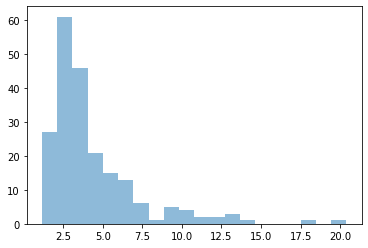

Bin Width: 0.8986661749591235
Num Bins: 21
Max Loss: 20.193029403686523
Min Loss: 1.162305474281311
Min Bin: 1.162305474281311
Max Bin: 21.355335235595703
Optimal Threshold: 6.450956032389685


In [9]:
"""
Utility Functions
"""
# Head tail break function
def htb(data):
    outp = []
    
    def htb_inner(data):
        data_length = float(len(data))
        data_mean = sum(data) / data_length
        
        head = [_ for _ in data if _ > data_mean]
        outp.append(data_mean)
        
        while len(head) > 1 and len(head) / data_length < 0.40:
            return htb_inner(head)
        
    htb_inner(data)
    
    return outp

# Determine a breakpoint
def fetch_threshold(bins, counts, break_point):
    index = 0
    latest_min = 999999
    threshold = -1
    
    for i in range(len(counts)):
        diff = abs(counts[i] - break_point)
        
        if diff <= latest_min:
            latest_min = diff
            index = i
            threshold = ((bins[i + 1] - bins[i]) / 2) + bins[i]
            
    return threshold

predictions = model(x)
targets = x

x_loss = nn.MSELoss(reduction='none')(predictions, targets).sum(axis=1).detach().cpu().numpy().astype(np.float32)

max_loss = np.max(x_loss)
min_loss = np.min(x_loss)

# Compute the optimal bin width using Freedman Diaconis rule
bin_width = 2 * (iqr(x_loss) / (len(x_loss) ** (1./3)))
num_bins = int((max_loss - min_loss) / bin_width)

# Create the histogram
min_bin = np.min(x_loss)
max_bin = np.max(x_loss) + min_bin

step = (max_bin - min_bin) / num_bins

bins = np.arange(min_bin, max_bin, step)

hist, bins = np.histogram(x_loss, bins=bins)

pyplot.hist(x_loss, bins, alpha=0.5)
pyplot.show()

print("Bin Width: {}".format(bin_width))
print("Num Bins: {}".format(num_bins))
print("Max Loss: {}".format(max_loss))
print("Min Loss: {}".format(min_loss))
print("Min Bin: {}".format(min_bin))
print("Max Bin: {}".format(max_bin))



# Determine breaks
breaks = htb(hist)

possible_thresholds = []

for b in breaks:
    t = fetch_threshold(bins, hist, b)
    possible_thresholds.append(t)

optimal_threshold = max(possible_thresholds)

print("Optimal Threshold: {}".format(optimal_threshold))

## Compute for Anomalies

In [10]:
# Convert test data to tensor
x = torch.tensor(df_test_x.values).float().to(device)

predictions = model(x)
targets = x

# Get reconstruction error
x_loss = nn.MSELoss(reduction='none')(predictions, targets).sum(axis=1).detach().cpu().numpy().astype(np.float32)

# If reconstruction error is >= than the optimal threshold, we consider it an anomaly
bool_arr = x_loss >= optimal_threshold

# Convert anomaly labels to -1 if True and 1 if False
anomaly_predictions = np.array([-1 if elem else 1 for elem in bool_arr])

# Build dataframe for test data and attach predictions
df_test_x_with_labels = df_test_x.copy()
df_test_x_with_labels['y'] = anomaly_predictions

df_test_x_with_labels

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x247,x248,x249,x250,x251,x252,x253,x254,x255,y
0,0.0,0.0,0.0,0.136317,0.197139,0.0,0.0,0.0,0.0,0.0,...,0.803803,0.639587,0.000000,0.639858,0.961619,0.756110,1.000000,0.501312,0.646729,-1
1,0.0,0.0,0.0,0.511960,0.395099,0.0,0.0,0.0,0.0,0.0,...,0.607391,0.957581,0.768478,0.083670,0.532594,0.781758,0.309138,0.500786,0.639648,-1
2,0.0,0.0,0.0,0.195061,0.236301,0.0,0.0,0.0,0.0,0.0,...,0.905935,0.000000,0.419056,1.000000,1.000000,0.693278,0.185259,0.418175,0.672119,-1
3,0.0,0.0,0.0,0.233787,0.469791,0.0,0.0,0.0,0.0,0.0,...,0.085258,0.980347,0.818207,0.224465,0.517853,0.677630,0.513420,0.873016,0.854248,-1
4,0.0,0.0,0.0,0.439786,0.407876,0.0,0.0,0.0,0.0,0.0,...,0.273043,0.777039,0.119640,0.014790,0.000000,0.000000,0.738972,1.000000,0.798584,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,0.0,0.0,0.0,0.694312,0.806908,0.0,0.0,0.0,0.0,0.0,...,0.579404,0.910217,0.551977,0.374937,0.616560,0.573696,0.281673,0.736748,0.941528,1
79,0.0,0.0,0.0,0.865906,0.682270,0.0,0.0,0.0,0.0,0.0,...,0.671028,0.832581,0.340963,0.215403,0.297065,0.580304,0.461682,0.466774,0.656982,-1
80,0.0,0.0,0.0,0.894467,0.586389,0.0,0.0,0.0,0.0,0.0,...,0.690107,0.885620,0.502222,0.458455,0.706895,1.000000,0.240549,0.586861,0.722290,-1
81,0.0,0.0,0.0,0.887946,0.938269,0.0,0.0,0.0,0.0,0.0,...,0.724395,0.859741,0.352997,0.221190,0.572805,0.674464,0.828842,0.463318,0.557373,-1


In [11]:
# # Fit a TSNE model with 3 dimensions
# z_embedded = TSNE(n_components=3, learning_rate='auto', init='random').fit_transform(df_test_x_with_labels.drop(columns=['y'], axis=1).values)

# # Create a new data frame for result of tsne and attach cluster label
# df_z_embedded = pd.DataFrame(z_embedded, columns=['x', 'y', 'z'])
# df_z_embedded['y'] = anomaly_predictions

# # Visualize with 3D scatterplot
# fig = px.scatter_3d(df_z_embedded, x='x', y='y', z='z', color='y')
# fig.show()

## Evaluation of Results

In [12]:
ground_truth = np.array([1 if elem == 1 else -1 for elem in df_test_y.values])

y_truth = np.array([0 if elem == -1 else 1 for elem in ground_truth])
y_predictions = np.array([0 if elem == -1 else 1 for elem in anomaly_predictions])

tn, fp, fn, tp = confusion_matrix(ground_truth, anomaly_predictions).ravel()
tn, fp, fn, tp = confusion_matrix(y_truth, y_predictions).ravel()

f1 = tp / (tp + 0.5* (fp + fn))

print("True Positive: {}".format(tp))
print("True Negative: {}".format(tn))
print("False Positive: {}".format(fp))
print("False Negative: {}".format(fn))
print("F1: {}".format(f1))

True Positive: 1
True Negative: 56
False Positive: 7
False Negative: 19
F1: 0.07142857142857142


In [13]:
def predict_proba(y, bool_a, errors, threshold, max_err):
    results = []
    
    for i in range(len(y)):
        if bool_a[i]:
            prob_anomaly = 0.5 + (1 - (threshold / x_loss[i]))
            
            if prob_anomaly > 1:
                prob_anomaly = 0.99
                
            prob_normal = 1 - prob_anomaly
                
            results.append([prob_normal, prob_anomaly])
        else:
            prob_normal = 0.5 + (1 - (x_loss[i] / threshold))
            
            if prob_normal > 1:
                prob_normal = 0.99
            
            prob_anomaly = 1 - prob_normal
            
            results.append([prob_normal, prob_anomaly])
    
    return results

y_probs = predict_proba(y_truth, bool_arr, x_loss, optimal_threshold, np.max(x_loss))

## ROC Curve and AUC

ROC AUC: 0.542857 



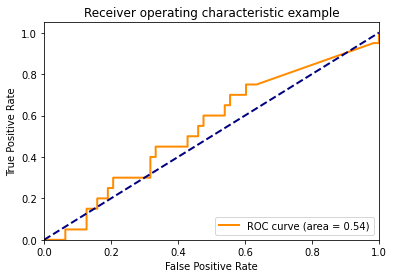

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve

def mapper(arr):
    return arr[0]

probabilities = list(map(mapper, y_probs))
# print(probabilities)

auc = roc_auc_score(y_truth, probabilities)
print('ROC AUC: %f' % auc, '\n')

fpr, tpr, _ = roc_curve(y_truth, probabilities)
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()